# Technical Analysis Research

## Process (step-by-step; run each cell to see progress)
1. **Indicator Zoo**: Build 20+ indicators → see them all
2. **Factor Zoo**: Convert to normalized factors (0–100) → many factors to choose from
3. **Correlation Analysis**: Find the most **uncorrelated** factors → avoid redundancy
4. **Try combos**: Bunch uncorrelated factors into 4-factor combos → score by IC + low correlation
5. **Parameter sweeps**: For top combos, try **buy earlier/later** (threshold), **RSI higher/lower** (oversold/overbought), MA periods, etc.
6. **Backtest**: Backtest each combo and each parameter set → compare results with visualizations
7. **Conclusion**: Pick the **best combo** and **best parameters** → use those **4 indicators as final**
8. **Export**: Final 4 factors + 16-scenario decision matrix for strategy designer

In [18]:
# ══════════════════════════════════════════════════════════════════════════════
# SETUP
# ══════════════════════════════════════════════════════════════════════════════
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')

# Style
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 200)

# ═══════════════════════════════════════════════════════════════════════
# CONFIG - EDIT THESE
# ═══════════════════════════════════════════════════════════════════════
UNIVERSE = 'KOSPI200'       # Change as needed
START_DATE = '2020-01-01'   # Change as needed  
END_DATE = '2025-12-31'     # Change as needed

print("=" * 60)
print("TECHNICAL ANALYSIS RESEARCH NOTEBOOK")
print("=" * 60)
print(f"Universe: {UNIVERSE}")
print(f"Period: {START_DATE} ~ {END_DATE}")
print("=" * 60)

TECHNICAL ANALYSIS RESEARCH NOTEBOOK
Universe: KOSPI200
Period: 2020-01-01 ~ 2025-12-31


📊 OHLCV Data Preview
Shape: 500 days x 5 columns
Date range: 2024-03-04 ~ 2026-01-30

                                    Open          High           Low         Close   Volume
2026-01-19 13:52:08.629800  62653.236303  63076.193751  62597.659876  62945.027136  1404752
2026-01-20 13:52:08.629800  66048.098534  66179.606204  63196.299116  64855.430270  1791418
2026-01-21 13:52:08.629800  64774.262358  65135.957109  64608.730865  64975.352733  1395597
2026-01-22 13:52:08.629800  64258.761783  64320.539834  63766.954852  63884.855185  1365854
2026-01-23 13:52:08.629800  65875.127500  66540.526108  64864.700216  65880.652312  1602943
2026-01-26 13:52:08.629800  66537.773466  66801.802726  65278.199303  66614.549034  1441289
2026-01-27 13:52:08.629800  66399.466765  66439.733710  63920.977425  65266.447576  1243677
2026-01-28 13:52:08.629800  64598.938643  65454.764972  64252.076848  65037.973760  1307316
2026-01-29 13:52:08.629800  64253.605154  64293.239478  63273.431957  63928.095628  15

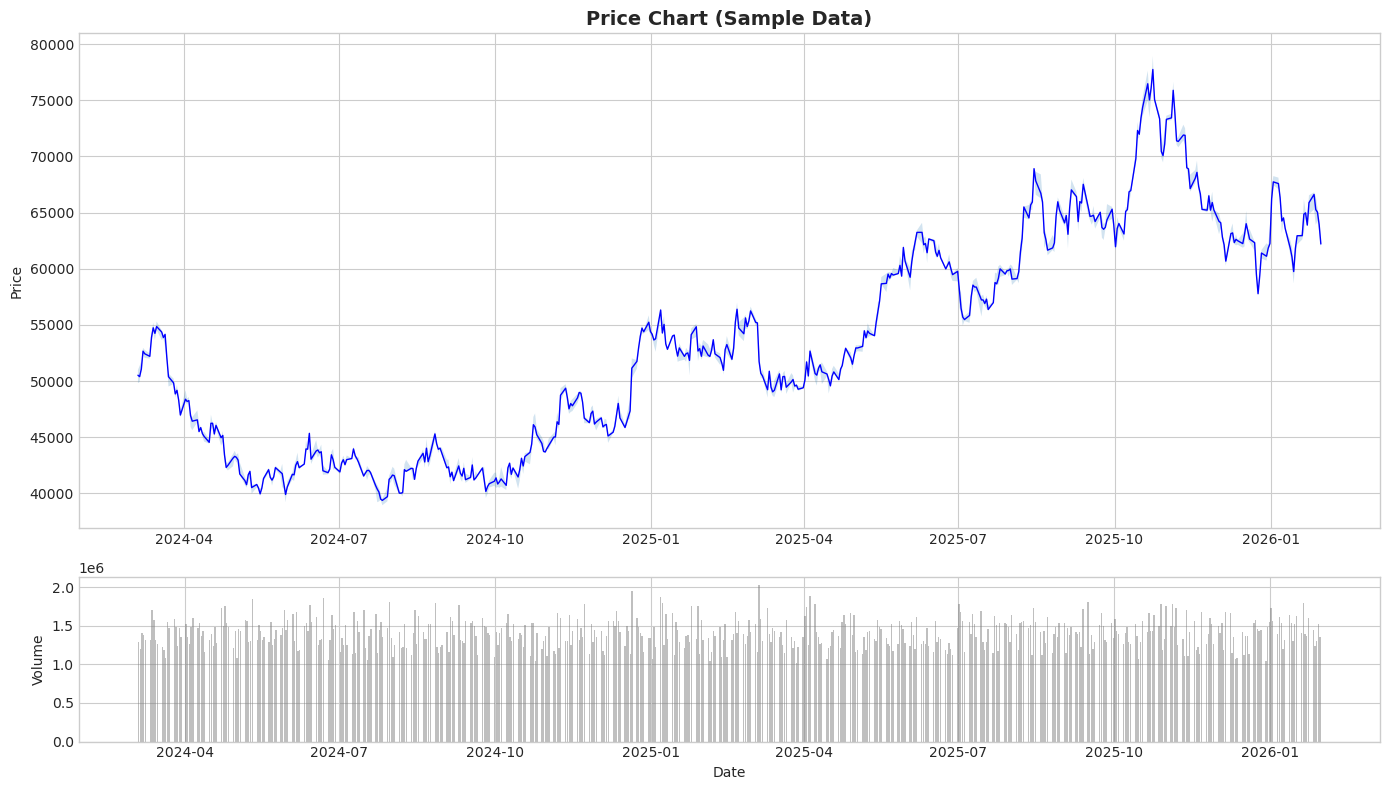


✓ Data loaded successfully


In [19]:
# ══════════════════════════════════════════════════════════════════════════════
# STEP 1: LOAD / GENERATE SAMPLE DATA
# ══════════════════════════════════════════════════════════════════════════════

def generate_sample_ohlcv(n_days=500, seed=42):
    """Generate realistic sample OHLCV data for testing"""
    np.random.seed(seed)
    
    dates = pd.date_range(end=pd.Timestamp.today(), periods=n_days, freq='B')
    
    # Generate price with trend + noise
    returns = np.random.randn(n_days) * 0.02 + 0.0003  # slight upward drift
    price = 50000 * np.exp(np.cumsum(returns))
    
    # Generate OHLC from close
    high = price * (1 + np.abs(np.random.randn(n_days)) * 0.01)
    low = price * (1 - np.abs(np.random.randn(n_days)) * 0.01)
    open_p = low + (high - low) * np.random.rand(n_days)
    
    # Volume with some correlation to price movement
    base_vol = 1000000
    vol = base_vol * (1 + np.abs(returns) * 10 + np.random.rand(n_days) * 0.5)
    
    ohlcv = pd.DataFrame({
        'Open': open_p,
        'High': high,
        'Low': low,
        'Close': price,
        'Volume': vol.astype(int)
    }, index=dates)
    
    return ohlcv

# ═══════════════════════════════════════════════════════════════════════
# TODO: Replace with your actual data loading
# ═══════════════════════════════════════════════════════════════════════
# ohlcv = load_your_data(ticker, START_DATE, END_DATE)

# For now, use sample data
ohlcv = generate_sample_ohlcv(n_days=500)

# ═══════════════════════════════════════════════════════════════════════
# PREVIEW DATA
# ═══════════════════════════════════════════════════════════════════════
print("📊 OHLCV Data Preview")
print("=" * 60)
print(f"Shape: {ohlcv.shape[0]} days x {ohlcv.shape[1]} columns")
print(f"Date range: {ohlcv.index[0].date()} ~ {ohlcv.index[-1].date()}")
print()
print(ohlcv.tail(10))

# Quick price chart
fig, axes = plt.subplots(2, 1, figsize=(14, 8), height_ratios=[3, 1])

# Price
axes[0].plot(ohlcv.index, ohlcv['Close'], 'b-', linewidth=1)
axes[0].fill_between(ohlcv.index, ohlcv['Low'], ohlcv['High'], alpha=0.2)
axes[0].set_title('Price Chart (Sample Data)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price')

# Volume
axes[1].bar(ohlcv.index, ohlcv['Volume'], color='gray', alpha=0.5)
axes[1].set_ylabel('Volume')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

print("\n✓ Data loaded successfully")

In [20]:
# ══════════════════════════════════════════════════════════════════════════════
# PART 1: INDICATOR ZOO (20+ indicators)
# ══════════════════════════════════════════════════════════════════════════════

def rolling(s, n): return s.rolling(n, min_periods=1)
def ma(s, n): return rolling(s, n).mean()
def ema(s, n): return s.ewm(span=n, adjust=False, min_periods=1).mean()
def std(s, n): return rolling(s, n).std()
def safe_div(a, b): return a / b.replace(0, np.nan)

class Indicators:
    """All technical indicators in one place"""
    
    # ===== TREND =====
    @staticmethod
    def sma(close, n=20):
        """Simple Moving Average"""
        return ma(close, n)
    
    @staticmethod
    def ema_(close, n=20):
        """Exponential Moving Average"""
        return ema(close, n)
    
    @staticmethod
    def macd(close, fast=12, slow=26, sig=9):
        """MACD: returns (macd, signal, histogram)"""
        m = ema(close, fast) - ema(close, slow)
        s = ema(m, sig)
        return m, s, m - s
    
    @staticmethod
    def adx(high, low, close, n=14):
        """Average Directional Index (trend strength)"""
        tr = pd.concat([high - low, (high - close.shift(1)).abs(), (low - close.shift(1)).abs()], axis=1).max(axis=1)
        atr = ma(tr, n)
        up = high - high.shift(1)
        down = low.shift(1) - low
        plus_dm = np.where((up > down) & (up > 0), up, 0)
        minus_dm = np.where((down > up) & (down > 0), down, 0)
        plus_di = 100 * ma(pd.Series(plus_dm, index=close.index), n) / atr
        minus_di = 100 * ma(pd.Series(minus_dm, index=close.index), n) / atr
        dx = 100 * (plus_di - minus_di).abs() / (plus_di + minus_di)
        return ma(dx, n).fillna(25)
    
    @staticmethod
    def supertrend(high, low, close, n=10, mult=3):
        """Supertrend: 1=uptrend, 0=downtrend"""
        tr = pd.concat([high - low, (high - close.shift(1)).abs(), (low - close.shift(1)).abs()], axis=1).max(axis=1)
        atr = ma(tr, n)
        hl2 = (high + low) / 2
        upper = hl2 + mult * atr
        lower = hl2 - mult * atr
        trend = pd.Series(1, index=close.index)
        for i in range(1, len(close)):
            if close.iloc[i] > upper.iloc[i-1]:
                trend.iloc[i] = 1
            elif close.iloc[i] < lower.iloc[i-1]:
                trend.iloc[i] = 0
            else:
                trend.iloc[i] = trend.iloc[i-1]
        return trend
    
    # ===== MOMENTUM =====
    @staticmethod
    def rsi(close, n=14):
        """Relative Strength Index (0-100)"""
        delta = close.diff()
        gain = delta.clip(lower=0).rolling(n, min_periods=1).mean()
        loss = (-delta.clip(upper=0)).rolling(n, min_periods=1).mean()
        return (100 - 100 / (1 + safe_div(gain, loss))).fillna(50)
    
    @staticmethod
    def stochastic(high, low, close, k=14, d=3):
        """Stochastic: returns (%K, %D)"""
        lowest = rolling(low, k).min()
        highest = rolling(high, k).max()
        k_line = 100 * safe_div(close - lowest, highest - lowest).fillna(50)
        d_line = ma(k_line, d)
        return k_line, d_line
    
    @staticmethod
    def williams_r(high, low, close, n=14):
        """Williams %R (-100 to 0, convert to 0-100)"""
        highest = rolling(high, n).max()
        lowest = rolling(low, n).min()
        wr = -100 * safe_div(highest - close, highest - lowest)
        return (wr + 100).fillna(50)  # Convert to 0-100
    
    @staticmethod
    def cci(high, low, close, n=20):
        """Commodity Channel Index"""
        tp = (high + low + close) / 3
        mean_dev = rolling(tp, n).apply(lambda x: np.abs(x - x.mean()).mean())
        return safe_div(tp - ma(tp, n), 0.015 * mean_dev).fillna(0)
    
    @staticmethod
    def roc(close, n=10):
        """Rate of Change (%)"""
        return ((close / close.shift(n)) - 1) * 100
    
    @staticmethod
    def momentum(close, n=10):
        """Price Momentum"""
        return close - close.shift(n)
    
    @staticmethod
    def tsi(close, fast=13, slow=25):
        """True Strength Index (-100 to 100)"""
        diff = close.diff()
        double_smooth = ema(ema(diff, slow), fast)
        double_smooth_abs = ema(ema(diff.abs(), slow), fast)
        return (100 * safe_div(double_smooth, double_smooth_abs)).fillna(0)
    
    # ===== VOLATILITY =====
    @staticmethod
    def atr(high, low, close, n=14):
        """Average True Range"""
        tr = pd.concat([high - low, (high - close.shift(1)).abs(), (low - close.shift(1)).abs()], axis=1).max(axis=1)
        return ma(tr, n)
    
    @staticmethod
    def bollinger(close, n=20, std_mult=2):
        """Bollinger Bands: returns (middle, upper, lower, %B, bandwidth)"""
        mid = ma(close, n)
        s = std(close, n)
        upper = mid + std_mult * s
        lower = mid - std_mult * s
        pct_b = safe_div(close - lower, upper - lower).fillna(0.5)
        bandwidth = safe_div(upper - lower, mid).fillna(0)
        return mid, upper, lower, pct_b, bandwidth
    
    @staticmethod
    def keltner(close, high, low, n=20, mult=2):
        """Keltner Channel: returns (middle, upper, lower)"""
        mid = ema(close, n)
        atr_val = Indicators.atr(high, low, close, n)
        return mid, mid + mult * atr_val, mid - mult * atr_val
    
    @staticmethod
    def donchian(high, low, n=20):
        """Donchian Channel: returns (upper, lower, middle)"""
        upper = rolling(high, n).max()
        lower = rolling(low, n).min()
        return upper, lower, (upper + lower) / 2
    
    # ===== VOLUME =====
    @staticmethod
    def obv(close, volume):
        """On-Balance Volume"""
        direction = np.sign(close.diff()).fillna(0)
        return (direction * volume).cumsum()
    
    @staticmethod
    def vwap(high, low, close, volume):
        """Volume Weighted Average Price"""
        tp = (high + low + close) / 3
        return (tp * volume).cumsum() / volume.cumsum()
    
    @staticmethod
    def mfi(high, low, close, volume, n=14):
        """Money Flow Index (0-100)"""
        tp = (high + low + close) / 3
        mf = tp * volume
        pos_mf = mf.where(tp > tp.shift(1), 0)
        neg_mf = mf.where(tp < tp.shift(1), 0)
        mfr = safe_div(rolling(pos_mf, n).sum(), rolling(neg_mf, n).sum())
        return (100 - 100 / (1 + mfr)).fillna(50)
    
    @staticmethod
    def cmf(high, low, close, volume, n=20):
        """Chaikin Money Flow (-1 to 1)"""
        mfv = safe_div((close - low) - (high - close), high - low) * volume
        return safe_div(rolling(mfv, n).sum(), rolling(volume, n).sum()).fillna(0)
    
    @staticmethod
    def volume_osc(volume, fast=5, slow=20):
        """Volume Oscillator (%)"""
        return ((ma(volume, fast) - ma(volume, slow)) / ma(volume, slow) * 100).fillna(0)

print("Indicator Zoo loaded: 20+ indicators available")

Indicator Zoo loaded: 20+ indicators available


📈 INDICATOR VISUALIZATION


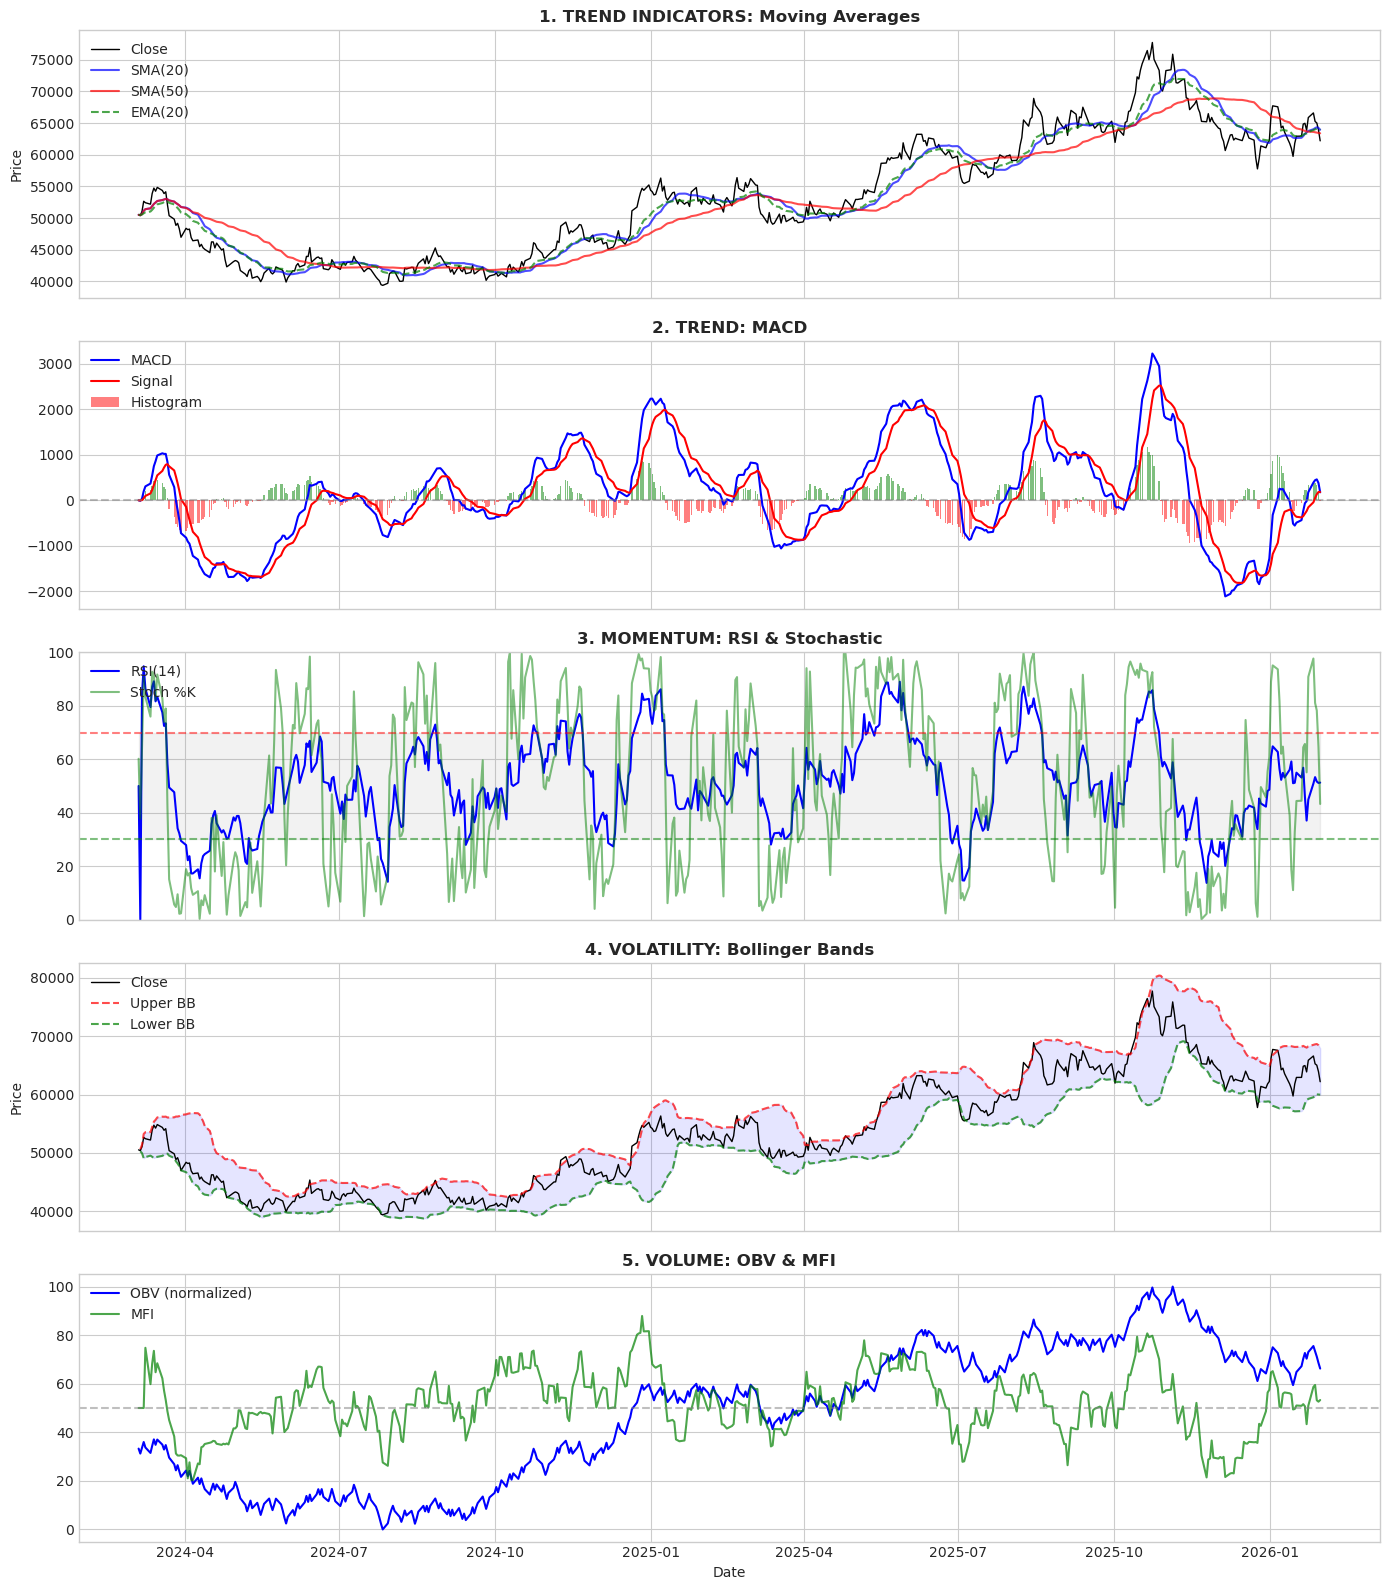


✓ Indicators visualized: MA, EMA, MACD, RSI, Stochastic, Bollinger, OBV, MFI


In [21]:
# ══════════════════════════════════════════════════════════════════════════════
# STEP 2a: VISUALIZE INDICATORS
# ══════════════════════════════════════════════════════════════════════════════

print("📈 INDICATOR VISUALIZATION")
print("=" * 60)

c, h, l, v = ohlcv['Close'], ohlcv['High'], ohlcv['Low'], ohlcv['Volume']

fig, axes = plt.subplots(5, 1, figsize=(14, 16), sharex=True)

# 1. Price with MAs
axes[0].plot(ohlcv.index, c, 'k-', linewidth=1, label='Close')
axes[0].plot(ohlcv.index, Indicators.sma(c, 20), 'b-', alpha=0.7, label='SMA(20)')
axes[0].plot(ohlcv.index, Indicators.sma(c, 50), 'r-', alpha=0.7, label='SMA(50)')
axes[0].plot(ohlcv.index, Indicators.ema_(c, 20), 'g--', alpha=0.7, label='EMA(20)')
axes[0].legend(loc='upper left')
axes[0].set_title('1. TREND INDICATORS: Moving Averages', fontweight='bold')
axes[0].set_ylabel('Price')

# 2. MACD
macd_line, signal, hist = Indicators.macd(c)
axes[1].plot(ohlcv.index, macd_line, 'b-', label='MACD')
axes[1].plot(ohlcv.index, signal, 'r-', label='Signal')
axes[1].bar(ohlcv.index, hist, color=['g' if x > 0 else 'r' for x in hist], alpha=0.5, label='Histogram')
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].legend(loc='upper left')
axes[1].set_title('2. TREND: MACD', fontweight='bold')

# 3. RSI + Stochastic
rsi = Indicators.rsi(c, 14)
stoch_k, stoch_d = Indicators.stochastic(h, l, c)
axes[2].plot(ohlcv.index, rsi, 'b-', label='RSI(14)')
axes[2].plot(ohlcv.index, stoch_k, 'g-', alpha=0.5, label='Stoch %K')
axes[2].axhline(y=70, color='r', linestyle='--', alpha=0.5)
axes[2].axhline(y=30, color='g', linestyle='--', alpha=0.5)
axes[2].fill_between(ohlcv.index, 30, 70, alpha=0.1, color='gray')
axes[2].set_ylim(0, 100)
axes[2].legend(loc='upper left')
axes[2].set_title('3. MOMENTUM: RSI & Stochastic', fontweight='bold')

# 4. Bollinger Bands + ATR
mid, upper, lower, pct_b, bw = Indicators.bollinger(c)
axes[3].plot(ohlcv.index, c, 'k-', linewidth=1, label='Close')
axes[3].plot(ohlcv.index, upper, 'r--', alpha=0.7, label='Upper BB')
axes[3].plot(ohlcv.index, lower, 'g--', alpha=0.7, label='Lower BB')
axes[3].fill_between(ohlcv.index, lower, upper, alpha=0.1, color='blue')
axes[3].legend(loc='upper left')
axes[3].set_title('4. VOLATILITY: Bollinger Bands', fontweight='bold')
axes[3].set_ylabel('Price')

# 5. Volume indicators
obv = Indicators.obv(c, v)
obv_normalized = (obv - obv.min()) / (obv.max() - obv.min()) * 100  # normalize for display
mfi = Indicators.mfi(h, l, c, v)
axes[4].plot(ohlcv.index, obv_normalized, 'b-', label='OBV (normalized)')
axes[4].plot(ohlcv.index, mfi, 'g-', alpha=0.7, label='MFI')
axes[4].axhline(y=50, color='gray', linestyle='--', alpha=0.5)
axes[4].legend(loc='upper left')
axes[4].set_title('5. VOLUME: OBV & MFI', fontweight='bold')
axes[4].set_xlabel('Date')

plt.tight_layout()
plt.show()

print("\n✓ Indicators visualized: MA, EMA, MACD, RSI, Stochastic, Bollinger, OBV, MFI")

In [22]:
# ══════════════════════════════════════════════════════════════════════════════
# PART 2: FACTOR ZOO (Convert indicators to 0-100 normalized factors)
# ══════════════════════════════════════════════════════════════════════════════

def normalize_0_100(s, low_pct=5, high_pct=95):
    """Normalize any series to 0-100 using percentile clipping"""
    low = s.quantile(low_pct / 100)
    high = s.quantile(high_pct / 100)
    clipped = s.clip(low, high)
    return ((clipped - low) / (high - low) * 100).fillna(50)

def invert(s):
    """Invert 0-100 scale (for volatility: low vol = high score)"""
    return 100 - s

class Factors:
    """Convert indicators to normalized factors (0-100)"""
    
    @staticmethod
    def compute_all(ohlcv, params=None):
        """
        Compute ALL factors from OHLCV data
        
        Args:
            ohlcv: DataFrame with [Open, High, Low, Close, Volume]
            params: dict of parameter overrides
        
        Returns:
            DataFrame with all factors (0-100 normalized)
        """
        p = params or {}
        c, h, l, v = ohlcv['Close'], ohlcv['High'], ohlcv['Low'], ohlcv['Volume']
        
        factors = pd.DataFrame(index=ohlcv.index)
        
        # ===== TREND FACTORS =====
        # MA Trend (price vs long MA)
        for n in p.get('ma_periods', [20, 50, 100, 200]):
            ratio = (c / Indicators.sma(c, n) - 1) * 100
            factors[f'F_MA{n}_Trend'] = normalize_0_100(ratio)
        
        # EMA Trend
        for n in p.get('ema_periods', [12, 26, 50]):
            ratio = (c / Indicators.ema_(c, n) - 1) * 100
            factors[f'F_EMA{n}_Trend'] = normalize_0_100(ratio)
        
        # MACD
        m, s, hist = Indicators.macd(c)
        factors['F_MACD_Line'] = normalize_0_100(m)
        factors['F_MACD_Hist'] = normalize_0_100(hist)
        
        # ADX (trend strength)
        factors['F_ADX'] = Indicators.adx(h, l, c)
        
        # Supertrend
        factors['F_Supertrend'] = Indicators.supertrend(h, l, c) * 100
        
        # ===== MOMENTUM FACTORS =====
        # RSI with different periods
        for n in p.get('rsi_periods', [7, 14, 21]):
            factors[f'F_RSI{n}'] = Indicators.rsi(c, n)
        
        # Stochastic
        for k in p.get('stoch_periods', [5, 14, 21]):
            k_line, d_line = Indicators.stochastic(h, l, c, k=k)
            factors[f'F_Stoch{k}_K'] = k_line
            factors[f'F_Stoch{k}_D'] = d_line
        
        # Williams %R
        factors['F_WilliamsR'] = Indicators.williams_r(h, l, c)
        
        # CCI
        factors['F_CCI'] = normalize_0_100(Indicators.cci(h, l, c))
        
        # ROC
        for n in p.get('roc_periods', [5, 10, 20]):
            factors[f'F_ROC{n}'] = normalize_0_100(Indicators.roc(c, n))
        
        # TSI
        factors['F_TSI'] = normalize_0_100(Indicators.tsi(c))
        
        # ===== VOLATILITY FACTORS =====
        # ATR (inverted: low vol = high score)
        atr_pct = Indicators.atr(h, l, c) / c * 100
        factors['F_ATR_Stability'] = invert(normalize_0_100(atr_pct))
        
        # Bollinger %B
        _, _, _, pct_b, bw = Indicators.bollinger(c)
        factors['F_BB_PctB'] = pct_b * 100
        factors['F_BB_Width'] = invert(normalize_0_100(bw))  # narrow = stable = high
        
        # ===== VOLUME FACTORS =====
        # OBV trend
        obv = Indicators.obv(c, v)
        obv_ma = ma(obv, 20)
        factors['F_OBV_Trend'] = normalize_0_100(obv - obv_ma)
        
        # MFI
        factors['F_MFI'] = Indicators.mfi(h, l, c, v)
        
        # CMF
        factors['F_CMF'] = normalize_0_100(Indicators.cmf(h, l, c, v))
        
        # Volume Oscillator
        factors['F_Vol_Osc'] = normalize_0_100(Indicators.volume_osc(v))
        
        return factors

print(f"Factor Zoo: Generates ~30 factors from OHLCV data")

Factor Zoo: Generates ~30 factors from OHLCV data


In [23]:
# ══════════════════════════════════════════════════════════════════════════════
# STEP 3a: GENERATE & PREVIEW ALL FACTORS
# ══════════════════════════════════════════════════════════════════════════════

print("🔢 GENERATING ALL FACTORS")
print("=" * 60)

# Generate all factors
all_factors = Factors.compute_all(ohlcv)

print(f"✓ Generated {len(all_factors.columns)} factors\n")

# Group by category
trend_factors = [c for c in all_factors.columns if 'MA' in c or 'EMA' in c or 'MACD' in c or 'ADX' in c or 'Super' in c]
momentum_factors = [c for c in all_factors.columns if 'RSI' in c or 'Stoch' in c or 'Williams' in c or 'CCI' in c or 'ROC' in c or 'TSI' in c]
volatility_factors = [c for c in all_factors.columns if 'ATR' in c or 'BB' in c]
volume_factors = [c for c in all_factors.columns if 'OBV' in c or 'MFI' in c or 'CMF' in c or 'Vol' in c]

print("📂 FACTORS BY CATEGORY:")
print("-" * 40)
print(f"\n🔵 TREND ({len(trend_factors)}):")
for f in trend_factors:
    print(f"   - {f}")

print(f"\n🟢 MOMENTUM ({len(momentum_factors)}):")
for f in momentum_factors:
    print(f"   - {f}")

print(f"\n🟡 VOLATILITY ({len(volatility_factors)}):")
for f in volatility_factors:
    print(f"   - {f}")

print(f"\n🟣 VOLUME ({len(volume_factors)}):")
for f in volume_factors:
    print(f"   - {f}")

# Preview
print("\n" + "=" * 60)
print("📋 FACTOR DATA PREVIEW (last 5 rows)")
print("=" * 60)
print(all_factors.tail().round(2).to_string())

# Summary statistics
print("\n" + "=" * 60)
print("📊 FACTOR STATISTICS")
print("=" * 60)
print(all_factors.describe().round(2).to_string())

🔢 GENERATING ALL FACTORS
✓ Generated 33 factors

📂 FACTORS BY CATEGORY:
----------------------------------------

🔵 TREND (11):
   - F_MA20_Trend
   - F_MA50_Trend
   - F_MA100_Trend
   - F_MA200_Trend
   - F_EMA12_Trend
   - F_EMA26_Trend
   - F_EMA50_Trend
   - F_MACD_Line
   - F_MACD_Hist
   - F_ADX
   - F_Supertrend

🟢 MOMENTUM (15):
   - F_RSI7
   - F_RSI14
   - F_RSI21
   - F_Stoch5_K
   - F_Stoch5_D
   - F_Stoch14_K
   - F_Stoch14_D
   - F_Stoch21_K
   - F_Stoch21_D
   - F_WilliamsR
   - F_CCI
   - F_ROC5
   - F_ROC10
   - F_ROC20
   - F_TSI

🟡 VOLATILITY (3):
   - F_ATR_Stability
   - F_BB_PctB
   - F_BB_Width

🟣 VOLUME (4):
   - F_OBV_Trend
   - F_MFI
   - F_CMF
   - F_Vol_Osc

📋 FACTOR DATA PREVIEW (last 5 rows)
                            F_MA20_Trend  F_MA50_Trend  F_MA100_Trend  F_MA200_Trend  F_EMA12_Trend  F_EMA26_Trend  F_EMA50_Trend  F_MACD_Line  F_MACD_Hist  F_ADX  F_Supertrend  F_RSI7  F_RSI14  F_RSI21  F_Stoch5_K  F_Stoch5_D  F_Stoch14_K  F_Stoch14_D  F_Stoch21_K  F

---
### Step 3c: Full factor & indicator list (what we're choosing from)

Below: every factor we can mix into combos. We'll pick the most uncorrelated ones and try different parameter settings (RSI higher/lower, buy earlier/later, etc.) then backtest to conclude on the best four.

📋 ALL FACTORS (candidates for combos)
         Factor    Category
   F_MA20_Trend  Trend (MA)
   F_MA50_Trend  Trend (MA)
  F_MA100_Trend  Trend (MA)
  F_MA200_Trend  Trend (MA)
  F_EMA12_Trend Trend (EMA)
  F_EMA26_Trend Trend (EMA)
  F_EMA50_Trend Trend (EMA)
    F_MACD_Line  Trend (MA)
    F_MACD_Hist  Trend (MA)
          F_ADX       Trend
   F_Supertrend       Trend
         F_RSI7    Momentum
        F_RSI14    Momentum
        F_RSI21    Momentum
     F_Stoch5_K    Momentum
     F_Stoch5_D    Momentum
    F_Stoch14_K    Momentum
    F_Stoch14_D    Momentum
    F_Stoch21_K    Momentum
    F_Stoch21_D    Momentum
    F_WilliamsR    Momentum
          F_CCI    Momentum
         F_ROC5    Momentum
        F_ROC10    Momentum
        F_ROC20    Momentum
          F_TSI    Momentum
F_ATR_Stability  Volatility
      F_BB_PctB  Volatility
     F_BB_Width  Volatility
    F_OBV_Trend      Volume
          F_MFI      Volume
          F_CMF      Volume
      F_Vol_Osc      Volume


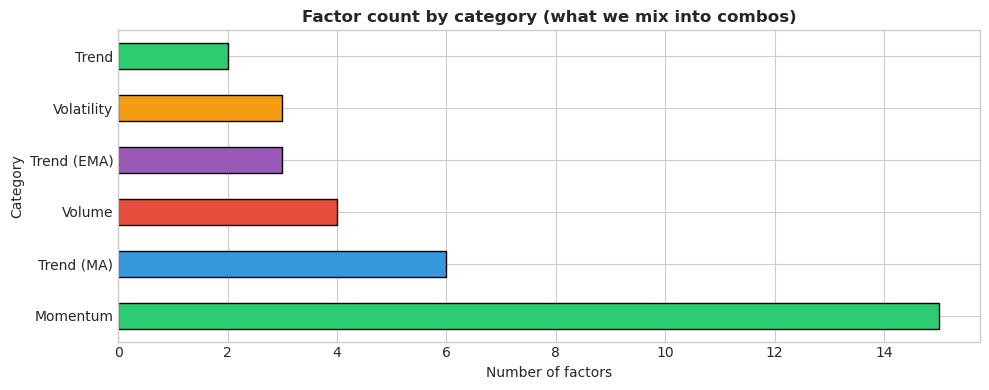


✓ Total: 33 factors → we will try combos, find uncorrelated ones, backtest, then pick best 4.


In [24]:
# Full list of factors we can use in combos (with category for comparison)
factor_list = []
for col in all_factors.columns:
    if 'MA' in col and 'EMA' not in col: cat = 'Trend (MA)'
    elif 'EMA' in col: cat = 'Trend (EMA)'
    elif 'MACD' in col or 'ADX' in col or 'Super' in col: cat = 'Trend'
    elif 'RSI' in col or 'Stoch' in col or 'Williams' in col or 'CCI' in col or 'ROC' in col or 'TSI' in col: cat = 'Momentum'
    elif 'ATR' in col or 'BB' in col: cat = 'Volatility'
    else: cat = 'Volume'
    factor_list.append({'Factor': col, 'Category': cat})

factor_list_df = pd.DataFrame(factor_list)
print("📋 ALL FACTORS (candidates for combos)")
print("=" * 60)
print(factor_list_df.to_string(index=False))

# Visualization: count by category
fig, ax = plt.subplots(figsize=(10, 4))
counts = factor_list_df['Category'].value_counts()
counts.plot(kind='barh', ax=ax, color=['#2ecc71', '#3498db', '#e74c3c', '#9b59b6', '#f39c12'], edgecolor='black')
ax.set_xlabel('Number of factors')
ax.set_title('Factor count by category (what we mix into combos)', fontweight='bold')
plt.tight_layout()
plt.show()
print(f"\n✓ Total: {len(all_factors.columns)} factors → we will try combos, find uncorrelated ones, backtest, then pick best 4.")

📊 FACTOR DISTRIBUTION ANALYSIS


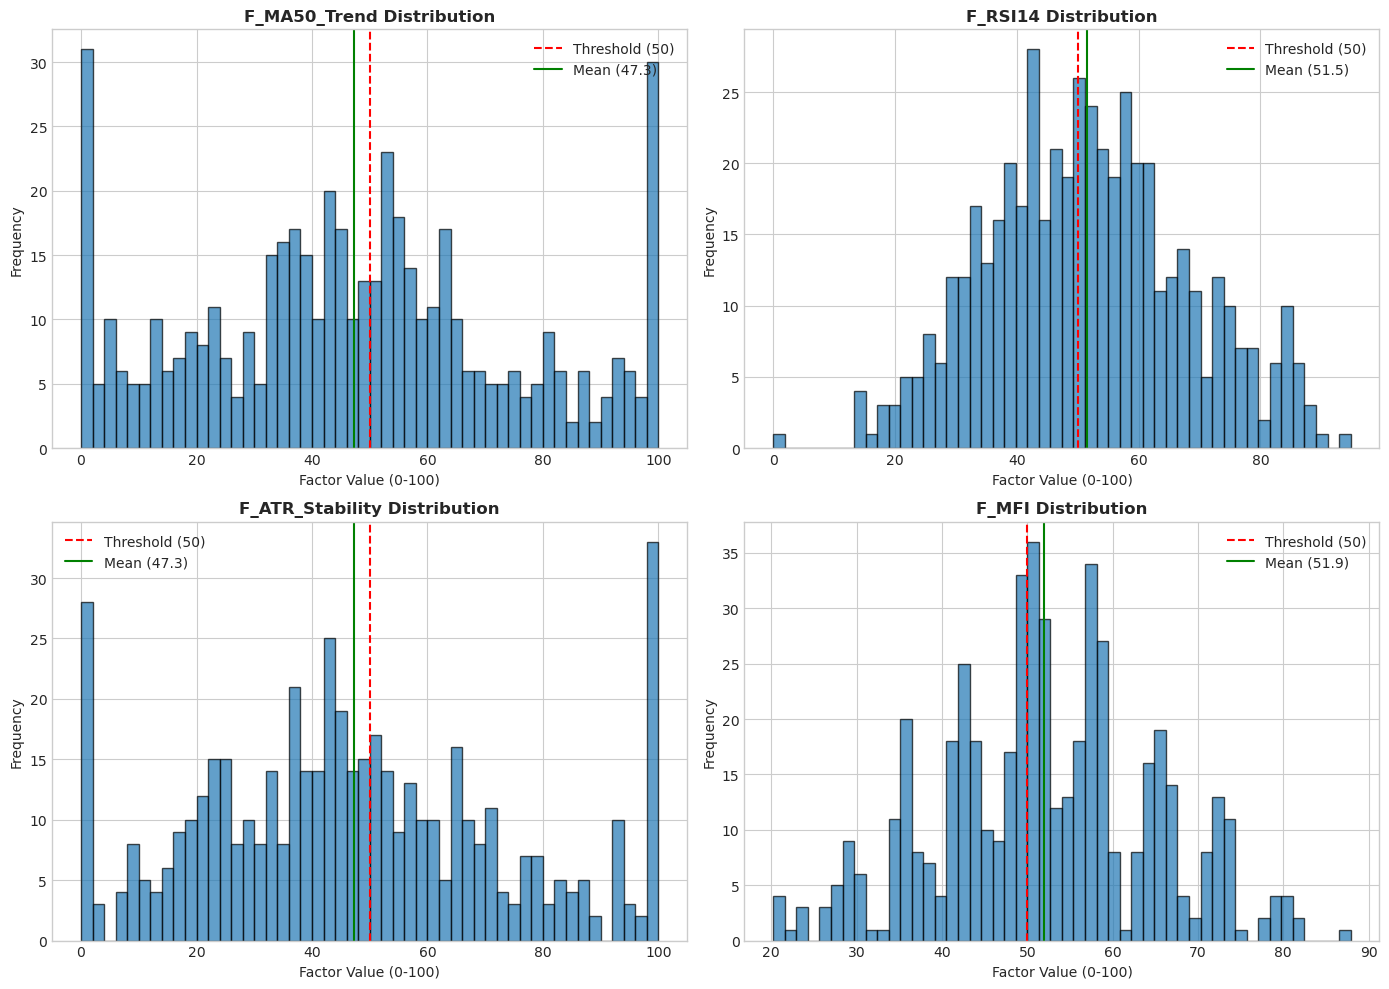


📈 FACTOR TIME SERIES


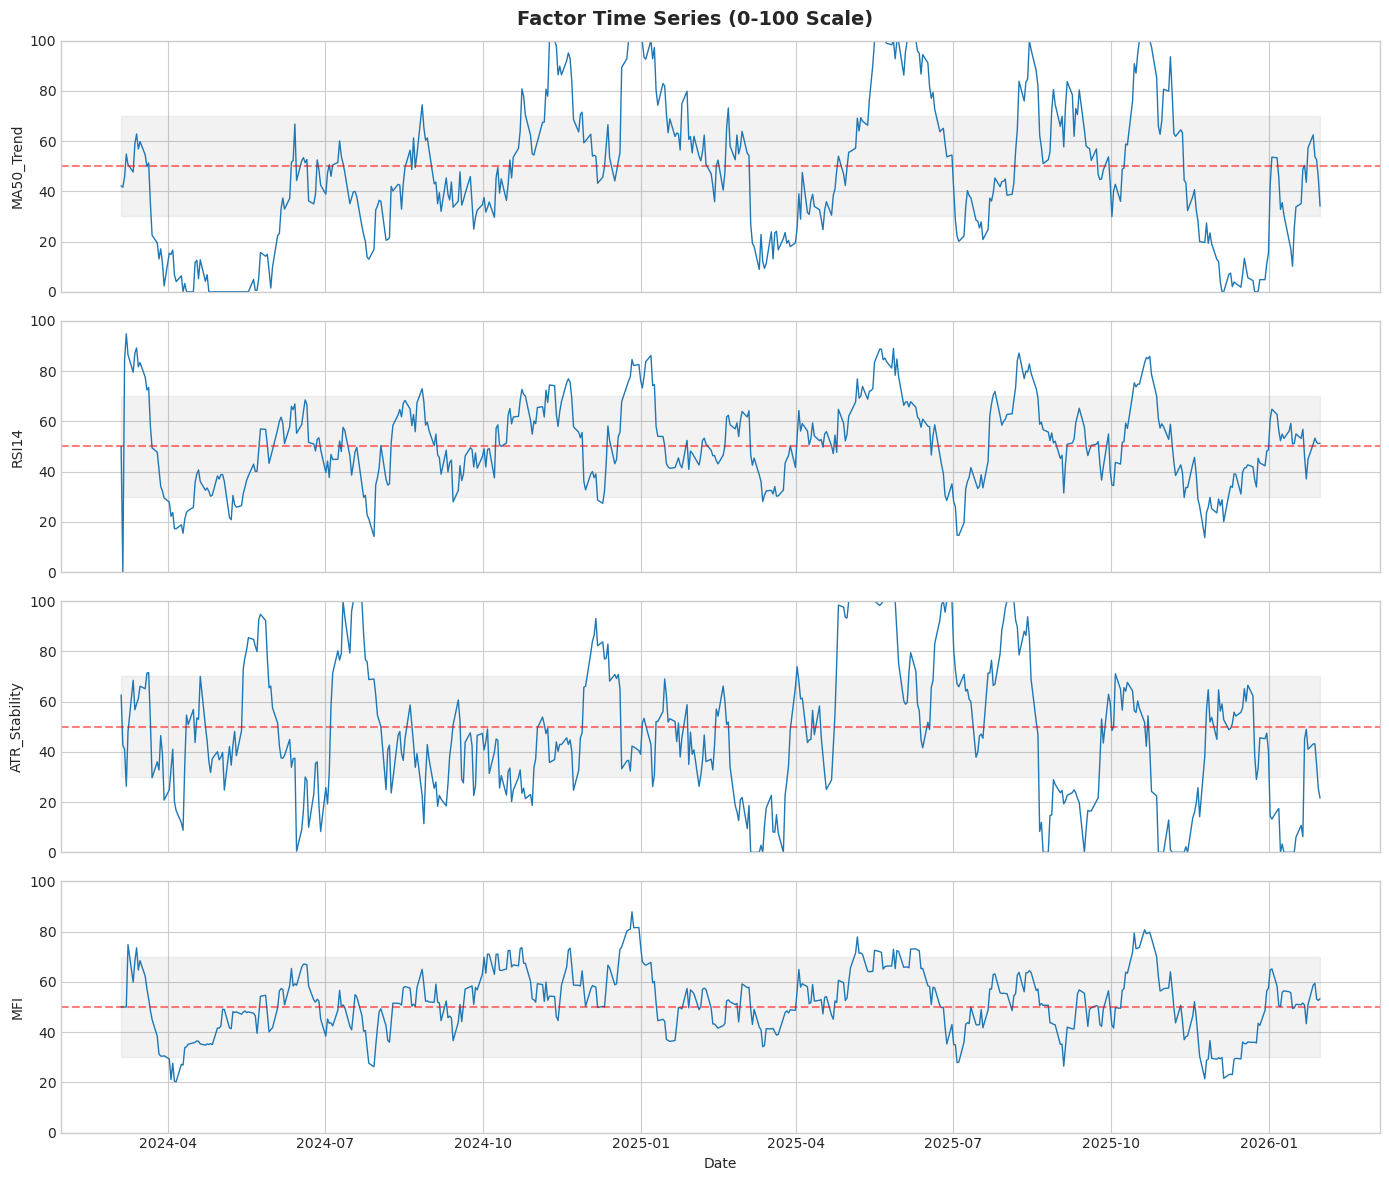


✓ Factor distributions and time series visualized


In [25]:
# ══════════════════════════════════════════════════════════════════════════════
# STEP 3b: VISUALIZE FACTOR DISTRIBUTIONS
# ══════════════════════════════════════════════════════════════════════════════

print("📊 FACTOR DISTRIBUTION ANALYSIS")
print("=" * 60)

# Select representative factors from each category
sample_factors = ['F_MA50_Trend', 'F_RSI14', 'F_ATR_Stability', 'F_MFI']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, factor in enumerate(sample_factors):
    if factor in all_factors.columns:
        ax = axes[i]
        ax.hist(all_factors[factor].dropna(), bins=50, edgecolor='black', alpha=0.7)
        ax.axvline(x=50, color='r', linestyle='--', label='Threshold (50)')
        ax.axvline(x=all_factors[factor].mean(), color='g', linestyle='-', label=f'Mean ({all_factors[factor].mean():.1f})')
        ax.set_title(f'{factor} Distribution', fontweight='bold')
        ax.set_xlabel('Factor Value (0-100)')
        ax.set_ylabel('Frequency')
        ax.legend()

plt.tight_layout()
plt.show()

# Time series of factors
print("\n📈 FACTOR TIME SERIES")
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

for i, factor in enumerate(sample_factors):
    if factor in all_factors.columns:
        axes[i].plot(all_factors.index, all_factors[factor], linewidth=1)
        axes[i].axhline(y=50, color='r', linestyle='--', alpha=0.5)
        axes[i].fill_between(all_factors.index, 30, 70, alpha=0.1, color='gray')
        axes[i].set_ylabel(factor.replace('F_', ''))
        axes[i].set_ylim(0, 100)

axes[-1].set_xlabel('Date')
plt.suptitle('Factor Time Series (0-100 Scale)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Factor distributions and time series visualized")

In [26]:
# ══════════════════════════════════════════════════════════════════════════════
# PART 3: CORRELATION ANALYSIS
# ══════════════════════════════════════════════════════════════════════════════

def analyze_correlations(factors_df, threshold=0.7):
    """
    Analyze factor correlations and find uncorrelated groups
    
    Args:
        factors_df: DataFrame with all factors
        threshold: correlation threshold for "too similar"
    
    Returns:
        corr_matrix, uncorrelated_factors
    """
    corr = factors_df.corr()
    
    # Plot heatmap
    plt.figure(figsize=(16, 12))
    sns.heatmap(corr, cmap='RdBu_r', center=0, annot=False, 
                xticklabels=True, yticklabels=True)
    plt.title('Factor Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Find highly correlated pairs
    high_corr_pairs = []
    for i in range(len(corr.columns)):
        for j in range(i+1, len(corr.columns)):
            if abs(corr.iloc[i, j]) > threshold:
                high_corr_pairs.append({
                    'Factor1': corr.columns[i],
                    'Factor2': corr.columns[j],
                    'Correlation': corr.iloc[i, j]
                })
    
    print(f"\nHighly correlated pairs (|r| > {threshold}):")
    if high_corr_pairs:
        print(pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False).to_string())
    else:
        print("None found")
    
    # Greedy selection of uncorrelated factors
    selected = []
    remaining = list(corr.columns)
    
    while remaining:
        # Pick first remaining
        pick = remaining[0]
        selected.append(pick)
        remaining.remove(pick)
        
        # Remove all highly correlated with pick
        to_remove = []
        for f in remaining:
            if abs(corr.loc[pick, f]) > threshold:
                to_remove.append(f)
        for f in to_remove:
            remaining.remove(f)
    
    print(f"\nUncorrelated factors ({len(selected)}):")
    for f in selected:
        print(f"  - {f}")
    
    return corr, selected


def find_best_combos(factors_df, returns, n_factors=4, top_k=10):
    """
    Find best factor combinations by testing all combos
    
    Args:
        factors_df: DataFrame with factors
        returns: Series of forward returns
        n_factors: number of factors per combo
        top_k: return top k combos
    """
    from scipy.stats import spearmanr
    
    factor_cols = [c for c in factors_df.columns if c.startswith('F_')]
    
    # Calculate IC for each factor
    factor_ic = {}
    merged = factors_df.join(returns, how='inner').dropna()
    for f in factor_cols:
        corr, _ = spearmanr(merged[f], merged[returns.name])
        factor_ic[f] = corr if not np.isnan(corr) else 0
    
    # Score combos by: sum of ICs + penalty for correlation
    corr_matrix = factors_df[factor_cols].corr()
    
    combo_scores = []
    for combo in combinations(factor_cols, n_factors):
        # Sum of ICs
        ic_sum = sum(abs(factor_ic[f]) for f in combo)
        
        # Average pairwise correlation (penalty)
        pairwise_corr = []
        for i, f1 in enumerate(combo):
            for f2 in combo[i+1:]:
                pairwise_corr.append(abs(corr_matrix.loc[f1, f2]))
        avg_corr = np.mean(pairwise_corr) if pairwise_corr else 0
        
        # Score: high IC, low correlation
        score = ic_sum * (1 - avg_corr)
        
        combo_scores.append({
            'Combo': combo,
            'IC_Sum': ic_sum,
            'Avg_Corr': avg_corr,
            'Score': score
        })
    
    # Sort by score
    results = pd.DataFrame(combo_scores).sort_values('Score', ascending=False)
    
    print(f"\nTop {top_k} factor combinations:")
    for i, row in results.head(top_k).iterrows():
        print(f"\n  Score: {row['Score']:.4f} (IC: {row['IC_Sum']:.4f}, Corr: {row['Avg_Corr']:.2f})")
        for f in row['Combo']:
            print(f"    - {f} (IC: {factor_ic[f]:.4f})")
    
    return results

🔗 CORRELATION ANALYSIS


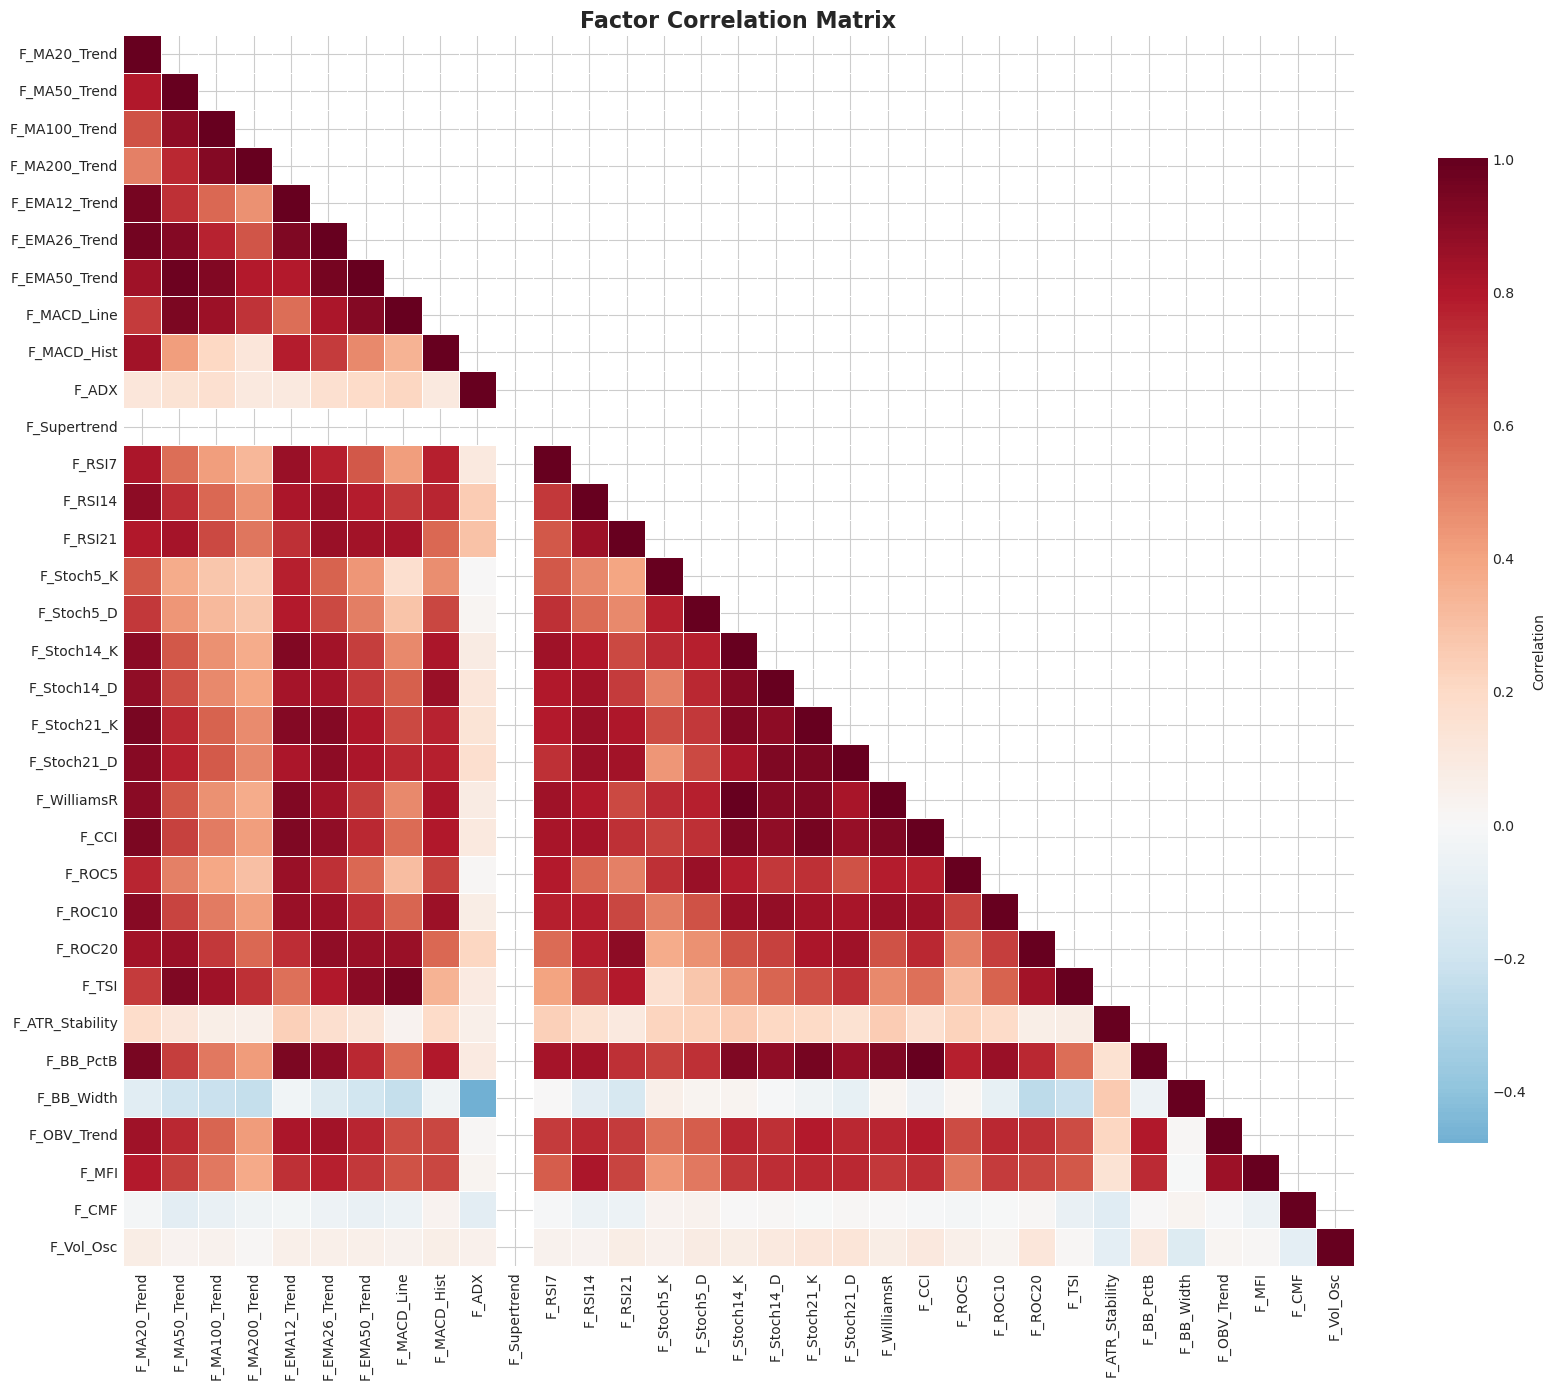


⚠️ HIGHLY CORRELATED PAIRS (|r| > 0.7):
------------------------------------------------------------
      Factor1       Factor2  Correlation
  F_Stoch14_K   F_WilliamsR        1.000
        F_CCI     F_BB_PctB        0.991
 F_MA50_Trend F_EMA50_Trend        0.979
 F_MA20_Trend F_EMA26_Trend        0.964
  F_MACD_Line         F_TSI        0.958
 F_MA20_Trend F_EMA12_Trend        0.955
  F_Stoch21_K     F_BB_PctB        0.951
  F_Stoch21_K         F_CCI        0.949
F_EMA26_Trend F_EMA50_Trend        0.948
 F_MA20_Trend     F_BB_PctB        0.944
 F_MA20_Trend   F_Stoch21_K        0.943
 F_MA50_Trend   F_MACD_Line        0.942
 F_MA20_Trend         F_CCI        0.939
F_EMA12_Trend     F_BB_PctB        0.938
  F_Stoch21_K   F_Stoch21_D        0.938
F_EMA12_Trend         F_CCI        0.934
  F_Stoch14_K     F_BB_PctB        0.930
  F_WilliamsR     F_BB_PctB        0.930
F_EMA12_Trend F_EMA26_Trend        0.929
  F_Stoch14_K         F_CCI        0.929
  F_WilliamsR         F_CCI        0.

In [27]:
# ══════════════════════════════════════════════════════════════════════════════
# STEP 4a: RUN CORRELATION ANALYSIS
# ══════════════════════════════════════════════════════════════════════════════

print("🔗 CORRELATION ANALYSIS")
print("=" * 60)

# Calculate correlation matrix
corr_matrix = all_factors.corr()

# Heatmap
plt.figure(figsize=(18, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0, 
            annot=False, square=True, linewidths=0.5,
            cbar_kws={'shrink': 0.8, 'label': 'Correlation'})
plt.title('Factor Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Find highly correlated pairs
THRESHOLD = 0.7
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > THRESHOLD:
            high_corr.append({
                'Factor1': corr_matrix.columns[i],
                'Factor2': corr_matrix.columns[j],
                'Correlation': round(corr_matrix.iloc[i, j], 3)
            })

print(f"\n⚠️ HIGHLY CORRELATED PAIRS (|r| > {THRESHOLD}):")
print("-" * 60)
if high_corr:
    high_corr_df = pd.DataFrame(high_corr).sort_values('Correlation', key=abs, ascending=False)
    print(high_corr_df.to_string(index=False))
else:
    print("No highly correlated pairs found.")

# Greedy selection of uncorrelated factors
print(f"\n✓ UNCORRELATED FACTOR SELECTION:")
print("-" * 60)
selected = []
remaining = list(corr_matrix.columns)

while remaining:
    pick = remaining[0]
    selected.append(pick)
    remaining.remove(pick)
    to_remove = [f for f in remaining if abs(corr_matrix.loc[pick, f]) > THRESHOLD]
    for f in to_remove:
        remaining.remove(f)

print(f"Selected {len(selected)} uncorrelated factors:")
for i, f in enumerate(selected, 1):
    category = "TREND" if any(x in f for x in ['MA', 'EMA', 'MACD', 'ADX', 'Super']) else \
               "MOMENTUM" if any(x in f for x in ['RSI', 'Stoch', 'Williams', 'CCI', 'ROC', 'TSI']) else \
               "VOLATILITY" if any(x in f for x in ['ATR', 'BB']) else "VOLUME"
    print(f"  {i:2}. {f:<25} [{category}]")

📈 INFORMATION COEFFICIENT ANALYSIS
IC = Spearman correlation between factor today and returns tomorrow
Higher |IC| = better predictive power

📊 FACTOR IC RANKING (sorted by |IC|):
------------------------------------------------------------
         Factor        IC      P-Value
     F_BB_Width  0.217927 9.817584e-07
F_ATR_Stability  0.134949 2.624558e-03
          F_CMF  0.128951 4.056622e-03
          F_ADX -0.116528 9.462431e-03
    F_MACD_Line -0.094346 3.586595e-02
          F_TSI -0.089831 4.575963e-02
   F_MA50_Trend -0.089323 4.700456e-02
  F_MA100_Trend -0.082163 6.777926e-02
      F_Vol_Osc -0.080340 7.412894e-02
  F_EMA50_Trend -0.076706 8.823127e-02
    F_Stoch14_D  0.073881 1.006228e-01
          F_MFI  0.071941 1.099068e-01
  F_MA200_Trend -0.071733 1.109418e-01
    F_MACD_Hist  0.061246 1.736836e-01
        F_RSI14  0.054886 2.228604e-01
  F_EMA26_Trend -0.054452 2.265390e-01
        F_ROC20 -0.048540 2.810949e-01
    F_OBV_Trend  0.040184 3.723146e-01
        F_RSI21 -0

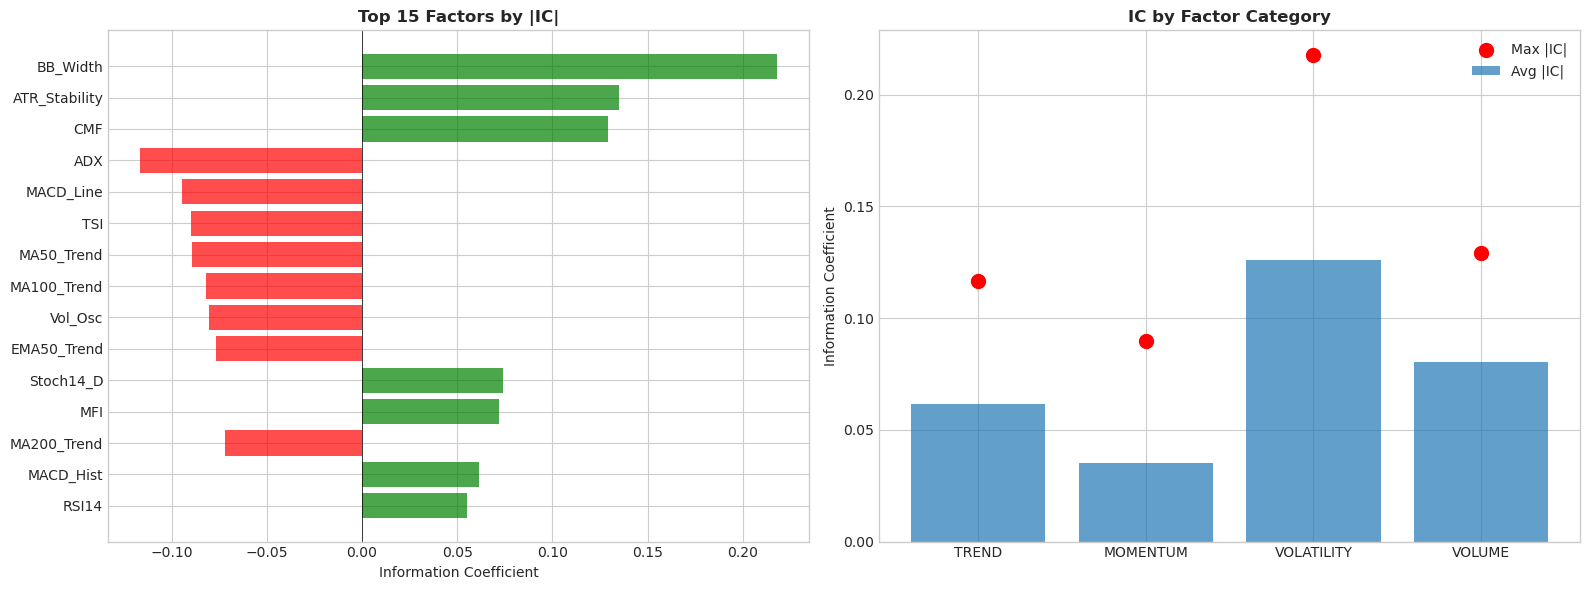


✓ IC analysis complete - use factors with high |IC| for better predictions


In [28]:
# ══════════════════════════════════════════════════════════════════════════════
# STEP 4b: INFORMATION COEFFICIENT (IC) ANALYSIS
# ══════════════════════════════════════════════════════════════════════════════

print("📈 INFORMATION COEFFICIENT ANALYSIS")
print("=" * 60)
print("IC = Spearman correlation between factor today and returns tomorrow")
print("Higher |IC| = better predictive power\n")

# Calculate forward returns
fwd_returns_5d = ohlcv['Close'].pct_change(5).shift(-5)  # 5-day forward return
fwd_returns_5d.name = 'Ret_5d'

# Calculate IC for each factor
ic_results = []
merged = all_factors.join(fwd_returns_5d, how='inner').dropna()

for factor in all_factors.columns:
    corr, pval = spearmanr(merged[factor], merged['Ret_5d'])
    ic_results.append({
        'Factor': factor,
        'IC': corr if not np.isnan(corr) else 0,
        'P-Value': pval if not np.isnan(pval) else 1,
        'Abs_IC': abs(corr) if not np.isnan(corr) else 0
    })

ic_df = pd.DataFrame(ic_results).sort_values('Abs_IC', ascending=False)

# Display results
print("📊 FACTOR IC RANKING (sorted by |IC|):")
print("-" * 60)
print(ic_df[['Factor', 'IC', 'P-Value']].head(20).to_string(index=False))

# Visualize IC
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of top factors
top_n = 15
top_factors = ic_df.head(top_n)
colors = ['green' if x > 0 else 'red' for x in top_factors['IC']]
axes[0].barh(range(len(top_factors)), top_factors['IC'], color=colors, alpha=0.7)
axes[0].set_yticks(range(len(top_factors)))
axes[0].set_yticklabels(top_factors['Factor'].str.replace('F_', ''))
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[0].set_xlabel('Information Coefficient')
axes[0].set_title(f'Top {top_n} Factors by |IC|', fontweight='bold')
axes[0].invert_yaxis()

# IC by category
categories = {
    'TREND': [c for c in all_factors.columns if any(x in c for x in ['MA', 'EMA', 'MACD', 'ADX', 'Super'])],
    'MOMENTUM': [c for c in all_factors.columns if any(x in c for x in ['RSI', 'Stoch', 'Williams', 'CCI', 'ROC', 'TSI'])],
    'VOLATILITY': [c for c in all_factors.columns if any(x in c for x in ['ATR', 'BB'])],
    'VOLUME': [c for c in all_factors.columns if any(x in c for x in ['OBV', 'MFI', 'CMF', 'Vol'])]
}

cat_ic = []
for cat, factors in categories.items():
    cat_ics = ic_df[ic_df['Factor'].isin(factors)]['Abs_IC']
    cat_ic.append({'Category': cat, 'Avg_IC': cat_ics.mean(), 'Max_IC': cat_ics.max()})

cat_df = pd.DataFrame(cat_ic)
x = range(len(cat_df))
axes[1].bar(x, cat_df['Avg_IC'], alpha=0.7, label='Avg |IC|')
axes[1].scatter(x, cat_df['Max_IC'], color='red', s=100, zorder=5, label='Max |IC|')
axes[1].set_xticks(x)
axes[1].set_xticklabels(cat_df['Category'])
axes[1].set_ylabel('Information Coefficient')
axes[1].set_title('IC by Factor Category', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n✓ IC analysis complete - use factors with high |IC| for better predictions")

In [29]:
# ══════════════════════════════════════════════════════════════════════════════
# STEP 4c: FIND BEST FACTOR COMBINATIONS
# ══════════════════════════════════════════════════════════════════════════════

print("🎯 FINDING BEST FACTOR COMBINATIONS")
print("=" * 60)
print("Goal: Find 4 uncorrelated factors with high predictive power")
print("Score = Sum(|IC|) × (1 - Avg_Correlation)\n")

# Use IC data from previous step
factor_ic = dict(zip(ic_df['Factor'], ic_df['IC']))

# Score factor combinations
factor_cols = list(all_factors.columns)
combo_scores = []

# Test all 4-factor combinations (limit for speed)
n_combinations = 0
for combo in combinations(factor_cols, 4):
    # Sum of ICs
    ic_sum = sum(abs(factor_ic.get(f, 0)) for f in combo)
    
    # Average pairwise correlation
    pairwise = []
    for i, f1 in enumerate(combo):
        for f2 in combo[i+1:]:
            pairwise.append(abs(corr_matrix.loc[f1, f2]))
    avg_corr = np.mean(pairwise)
    
    # Score: high IC, low correlation
    score = ic_sum * (1 - avg_corr)
    
    combo_scores.append({
        'Combo': combo,
        'IC_Sum': ic_sum,
        'Avg_Corr': avg_corr,
        'Score': score
    })
    n_combinations += 1

combo_df = pd.DataFrame(combo_scores).sort_values('Score', ascending=False)

print(f"Evaluated {n_combinations:,} combinations\n")

# Show top 10 combinations
print("🏆 TOP 10 FACTOR COMBINATIONS:")
print("-" * 80)
for rank, (_, row) in enumerate(combo_df.head(10).iterrows(), 1):
    print(f"\n#{rank} Score: {row['Score']:.4f} (IC Sum: {row['IC_Sum']:.4f}, Avg Corr: {row['Avg_Corr']:.2f})")
    for f in row['Combo']:
        ic = factor_ic.get(f, 0)
        print(f"    {'✓' if ic > 0 else '✗'} {f:<25} IC: {ic:+.4f}")

# Store best combo for later
best_combo = combo_df.iloc[0]['Combo']
print("\n" + "=" * 60)
print(f"✓ RECOMMENDED: {best_combo}")

🎯 FINDING BEST FACTOR COMBINATIONS
Goal: Find 4 uncorrelated factors with high predictive power
Score = Sum(|IC|) × (1 - Avg_Correlation)

Evaluated 40,920 combinations

🏆 TOP 10 FACTOR COMBINATIONS:
--------------------------------------------------------------------------------

#1 Score: 0.5048 (IC Sum: 0.5762, Avg Corr: 0.12)
    ✗ F_MACD_Line               IC: -0.0943
    ✓ F_ATR_Stability           IC: +0.1349
    ✓ F_BB_Width                IC: +0.2179
    ✓ F_CMF                     IC: +0.1290

#2 Score: 0.4982 (IC Sum: 0.5717, Avg Corr: 0.13)
    ✗ F_TSI                     IC: -0.0898
    ✓ F_ATR_Stability           IC: +0.1349
    ✓ F_BB_Width                IC: +0.2179
    ✓ F_CMF                     IC: +0.1290

#3 Score: 0.4969 (IC Sum: 0.5538, Avg Corr: 0.10)
    ✓ F_ATR_Stability           IC: +0.1349
    ✓ F_BB_Width                IC: +0.2179
    ✓ F_MFI                     IC: +0.0719
    ✓ F_CMF                     IC: +0.1290

#4 Score: 0.4964 (IC Sum: 0.5557, Avg

In [30]:
# ══════════════════════════════════════════════════════════════════════════════
# PART 4: PARAMETER OPTIMIZATION
# ══════════════════════════════════════════════════════════════════════════════

def optimize_rsi_thresholds(close, returns, periods=[7, 14, 21], 
                            oversold_range=range(20, 40, 5),
                            overbought_range=range(60, 85, 5)):
    """
    Test different RSI thresholds to find optimal buy/sell levels
    """
    results = []
    
    for period in periods:
        rsi_val = Indicators.rsi(close, period)
        
        for oversold in oversold_range:
            for overbought in overbought_range:
                if overbought <= oversold:
                    continue
                
                # Buy signal: RSI crosses above oversold
                buy = (rsi_val > oversold) & (rsi_val.shift(1) <= oversold)
                
                # Calculate avg return after buy signal
                merged = pd.DataFrame({'buy': buy, 'ret': returns}).dropna()
                avg_ret = merged[merged['buy']]['ret'].mean()
                n_signals = merged['buy'].sum()
                
                results.append({
                    'Period': period,
                    'Oversold': oversold,
                    'Overbought': overbought,
                    'Avg_Return': avg_ret,
                    'N_Signals': n_signals
                })
    
    df = pd.DataFrame(results).sort_values('Avg_Return', ascending=False)
    
    print("RSI Threshold Optimization:")
    print(df.head(10).to_string())
    
    return df


def optimize_ma_crossover(close, returns, short_range=range(5, 30, 5),
                          long_range=range(20, 100, 10)):
    """
    Test different MA crossover combinations
    """
    results = []
    
    for short in short_range:
        for long in long_range:
            if long <= short:
                continue
            
            ma_short = Indicators.sma(close, short)
            ma_long = Indicators.sma(close, long)
            
            # Golden cross
            buy = (ma_short > ma_long) & (ma_short.shift(1) <= ma_long.shift(1))
            
            merged = pd.DataFrame({'buy': buy, 'ret': returns}).dropna()
            avg_ret = merged[merged['buy']]['ret'].mean()
            n_signals = merged['buy'].sum()
            
            results.append({
                'Short_MA': short,
                'Long_MA': long,
                'Avg_Return': avg_ret,
                'N_Signals': n_signals
            })
    
    df = pd.DataFrame(results).sort_values('Avg_Return', ascending=False)
    
    print("\nMA Crossover Optimization:")
    print(df.head(10).to_string())
    
    return df

🔧 RSI THRESHOLD OPTIMIZATION
Testing different oversold/overbought levels

📊 TOP 10 RSI CONFIGURATIONS:
------------------------------------------------------------
 Period  Oversold  Overbought  Avg_Return  N_Signals
     21        20          75    0.018809          3
     21        20          70    0.018809          3
     21        20          65    0.018809          3
     21        20          60    0.018809          3
     21        20          80    0.018809          3
     21        35          75    0.009361         18
     21        35          80    0.009361         18
     21        35          70    0.009361         18
     21        35          65    0.009361         18
     21        35          60    0.009361         18


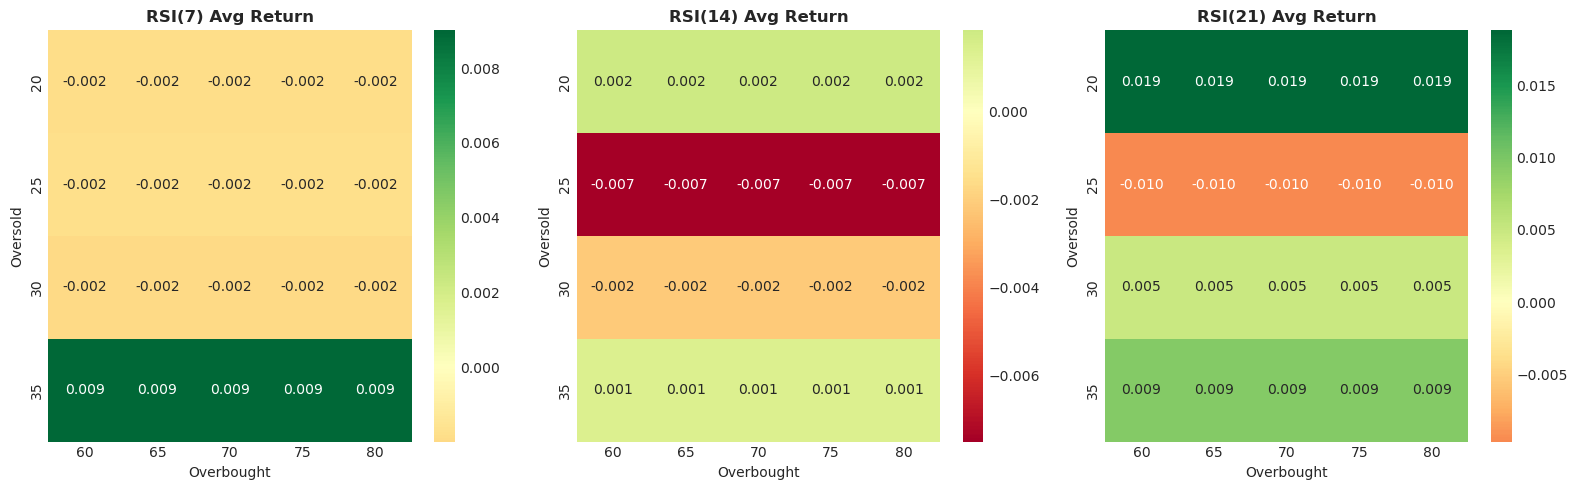


✓ BEST RSI CONFIG: Period=21, Oversold=20, Overbought=75


In [31]:
# ══════════════════════════════════════════════════════════════════════════════
# STEP 5a: PARAMETER OPTIMIZATION - RSI THRESHOLDS
# ══════════════════════════════════════════════════════════════════════════════

print("🔧 RSI THRESHOLD OPTIMIZATION")
print("=" * 60)
print("Testing different oversold/overbought levels\n")

c = ohlcv['Close']
returns = c.pct_change(5).shift(-5)  # 5-day forward returns

rsi_results = []
for period in [7, 14, 21]:
    rsi_val = Indicators.rsi(c, period)
    
    for oversold in range(20, 40, 5):
        for overbought in range(60, 85, 5):
            if overbought <= oversold:
                continue
            
            # Buy when RSI crosses above oversold
            buy_signal = (rsi_val > oversold) & (rsi_val.shift(1) <= oversold)
            
            merged = pd.DataFrame({'buy': buy_signal, 'ret': returns}).dropna()
            if merged['buy'].sum() > 0:
                avg_ret = merged[merged['buy']]['ret'].mean()
                n_signals = int(merged['buy'].sum())
                
                rsi_results.append({
                    'Period': period,
                    'Oversold': oversold,
                    'Overbought': overbought,
                    'Avg_Return': avg_ret,
                    'N_Signals': n_signals
                })

rsi_opt_df = pd.DataFrame(rsi_results).sort_values('Avg_Return', ascending=False)

print("📊 TOP 10 RSI CONFIGURATIONS:")
print("-" * 60)
print(rsi_opt_df.head(10).to_string(index=False))

# Heatmap of returns by oversold/period
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for i, period in enumerate([7, 14, 21]):
    subset = rsi_opt_df[rsi_opt_df['Period'] == period]
    pivot = subset.pivot_table(values='Avg_Return', index='Oversold', columns='Overbought', aggfunc='mean')
    if not pivot.empty:
        sns.heatmap(pivot, ax=axes[i], cmap='RdYlGn', center=0, annot=True, fmt='.3f')
        axes[i].set_title(f'RSI({period}) Avg Return', fontweight='bold')

plt.tight_layout()
plt.show()

# Best parameters
best_rsi = rsi_opt_df.iloc[0]
print(f"\n✓ BEST RSI CONFIG: Period={int(best_rsi['Period'])}, Oversold={int(best_rsi['Oversold'])}, Overbought={int(best_rsi['Overbought'])}")

🔧 MA CROSSOVER OPTIMIZATION
Testing different short/long MA combinations

📊 TOP 10 MA CROSSOVER CONFIGURATIONS:
------------------------------------------------------------
 Short_MA  Long_MA  Avg_Return  N_Signals
        5       80    0.054831          4
        5       90    0.044719          4
        5       50    0.030534         12
       15       30    0.029159         10
       15       40    0.024753         10
        5       40    0.023422         12
       10       50    0.021210          7
       25       30    0.018503         14
        5       30    0.015892         13
       15       80    0.015219          4


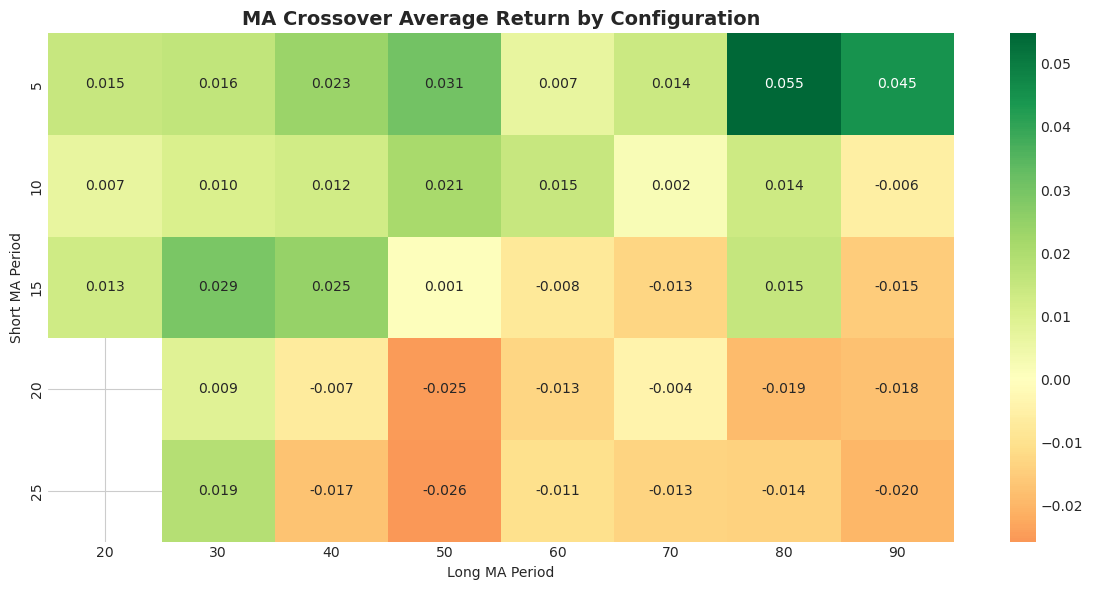


✓ BEST MA CROSSOVER: Short=5, Long=80


In [32]:
# ══════════════════════════════════════════════════════════════════════════════
# STEP 5b: PARAMETER OPTIMIZATION - MA CROSSOVER
# ══════════════════════════════════════════════════════════════════════════════

print("🔧 MA CROSSOVER OPTIMIZATION")
print("=" * 60)
print("Testing different short/long MA combinations\n")

ma_results = []
for short in range(5, 30, 5):
    for long in range(20, 100, 10):
        if long <= short:
            continue
        
        ma_short = Indicators.sma(c, short)
        ma_long = Indicators.sma(c, long)
        
        # Golden cross: short crosses above long
        buy_signal = (ma_short > ma_long) & (ma_short.shift(1) <= ma_long.shift(1))
        
        merged = pd.DataFrame({'buy': buy_signal, 'ret': returns}).dropna()
        if merged['buy'].sum() > 0:
            avg_ret = merged[merged['buy']]['ret'].mean()
            n_signals = int(merged['buy'].sum())
            
            ma_results.append({
                'Short_MA': short,
                'Long_MA': long,
                'Avg_Return': avg_ret,
                'N_Signals': n_signals
            })

ma_opt_df = pd.DataFrame(ma_results).sort_values('Avg_Return', ascending=False)

print("📊 TOP 10 MA CROSSOVER CONFIGURATIONS:")
print("-" * 60)
print(ma_opt_df.head(10).to_string(index=False))

# Heatmap
pivot = ma_opt_df.pivot_table(values='Avg_Return', index='Short_MA', columns='Long_MA', aggfunc='mean')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='RdYlGn', center=0, annot=True, fmt='.3f')
plt.title('MA Crossover Average Return by Configuration', fontsize=14, fontweight='bold')
plt.xlabel('Long MA Period')
plt.ylabel('Short MA Period')
plt.tight_layout()
plt.show()

# Best parameters
best_ma = ma_opt_df.iloc[0]
print(f"\n✓ BEST MA CROSSOVER: Short={int(best_ma['Short_MA'])}, Long={int(best_ma['Long_MA'])}")

In [33]:
# ══════════════════════════════════════════════════════════════════════════════
# PART 5: BACKTESTING
# ══════════════════════════════════════════════════════════════════════════════

def backtest_factor_combo(factors_df, returns, factor_combo, 
                          threshold=50, rebalance_freq='M'):
    """
    Backtest a factor combination
    
    Strategy: 
    - Buy when composite score > threshold
    - Equal weight all selected factors
    
    Returns:
        Performance metrics
    """
    # Composite score
    composite = factors_df[list(factor_combo)].mean(axis=1)
    
    # Position: 1 if composite > threshold, else 0
    position = (composite > threshold).astype(int)
    
    # Strategy returns
    merged = pd.DataFrame({
        'position': position,
        'returns': returns
    }).dropna()
    
    merged['strat_ret'] = merged['position'].shift(1) * merged['returns']
    merged['cum_ret'] = (1 + merged['strat_ret']).cumprod()
    merged['bh_cum'] = (1 + merged['returns']).cumprod()
    
    # Metrics
    total_ret = merged['cum_ret'].iloc[-1] - 1
    bh_ret = merged['bh_cum'].iloc[-1] - 1
    sharpe = merged['strat_ret'].mean() / merged['strat_ret'].std() * np.sqrt(252)
    max_dd = (merged['cum_ret'] / merged['cum_ret'].cummax() - 1).min()
    win_rate = (merged['strat_ret'] > 0).mean()
    
    return {
        'Factors': factor_combo,
        'Total_Return': total_ret,
        'Buy_Hold': bh_ret,
        'Excess_Return': total_ret - bh_ret,
        'Sharpe': sharpe,
        'Max_DD': max_dd,
        'Win_Rate': win_rate,
        'curve': merged[['cum_ret', 'bh_cum']]
    }


def compare_factor_combos(factors_df, returns, combos, threshold=50):
    """
    Compare multiple factor combinations
    """
    results = []
    
    for combo in combos:
        bt = backtest_factor_combo(factors_df, returns, combo, threshold)
        results.append({
            'Combo': ' + '.join([f.replace('F_', '') for f in combo]),
            'Return': bt['Total_Return'],
            'Excess': bt['Excess_Return'],
            'Sharpe': bt['Sharpe'],
            'MaxDD': bt['Max_DD'],
            'WinRate': bt['Win_Rate']
        })
    
    df = pd.DataFrame(results).sort_values('Sharpe', ascending=False)
    
    print("\nFactor Combo Comparison:")
    print(df.to_string())
    
    return df


def plot_backtest(bt_result):
    """Plot backtest equity curve"""
    curve = bt_result['curve']
    
    plt.figure(figsize=(12, 6))
    plt.plot(curve.index, curve['cum_ret'], label='Strategy', linewidth=2)
    plt.plot(curve.index, curve['bh_cum'], label='Buy & Hold', linewidth=1, alpha=0.7)
    plt.title(f"Backtest: {' + '.join([f.replace('F_', '') for f in bt_result['Factors']])}")
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Total Return: {bt_result['Total_Return']:.2%}")
    print(f"Buy & Hold: {bt_result['Buy_Hold']:.2%}")
    print(f"Excess Return: {bt_result['Excess_Return']:.2%}")
    print(f"Sharpe Ratio: {bt_result['Sharpe']:.2f}")
    print(f"Max Drawdown: {bt_result['Max_DD']:.2%}")

📈 BACKTESTING TOP FACTOR COMBINATIONS
📊 BACKTEST RESULTS:
--------------------------------------------------------------------------------
                                     Combo   Return  BuyHold   Excess   Sharpe     MaxDD  WinRate
MACD_Line + ATR_Stability + BB_Width + CMF 0.427385 0.231393 0.195993 0.869741 -0.193294 0.533101
      TSI + ATR_Stability + BB_Width + CMF 0.349740 0.231393 0.118347 0.752224 -0.204949 0.527586
      ATR_Stability + BB_Width + MFI + CMF 0.612692 0.231393 0.381300 1.158842 -0.231714 0.535461
Stoch14_D + ATR_Stability + BB_Width + CMF 0.538834 0.231393 0.307442 1.052155 -0.171857 0.531915
      ADX + ATR_Stability + BB_Width + CMF 0.420216 0.231393 0.188823 1.045646 -0.183317 0.541872


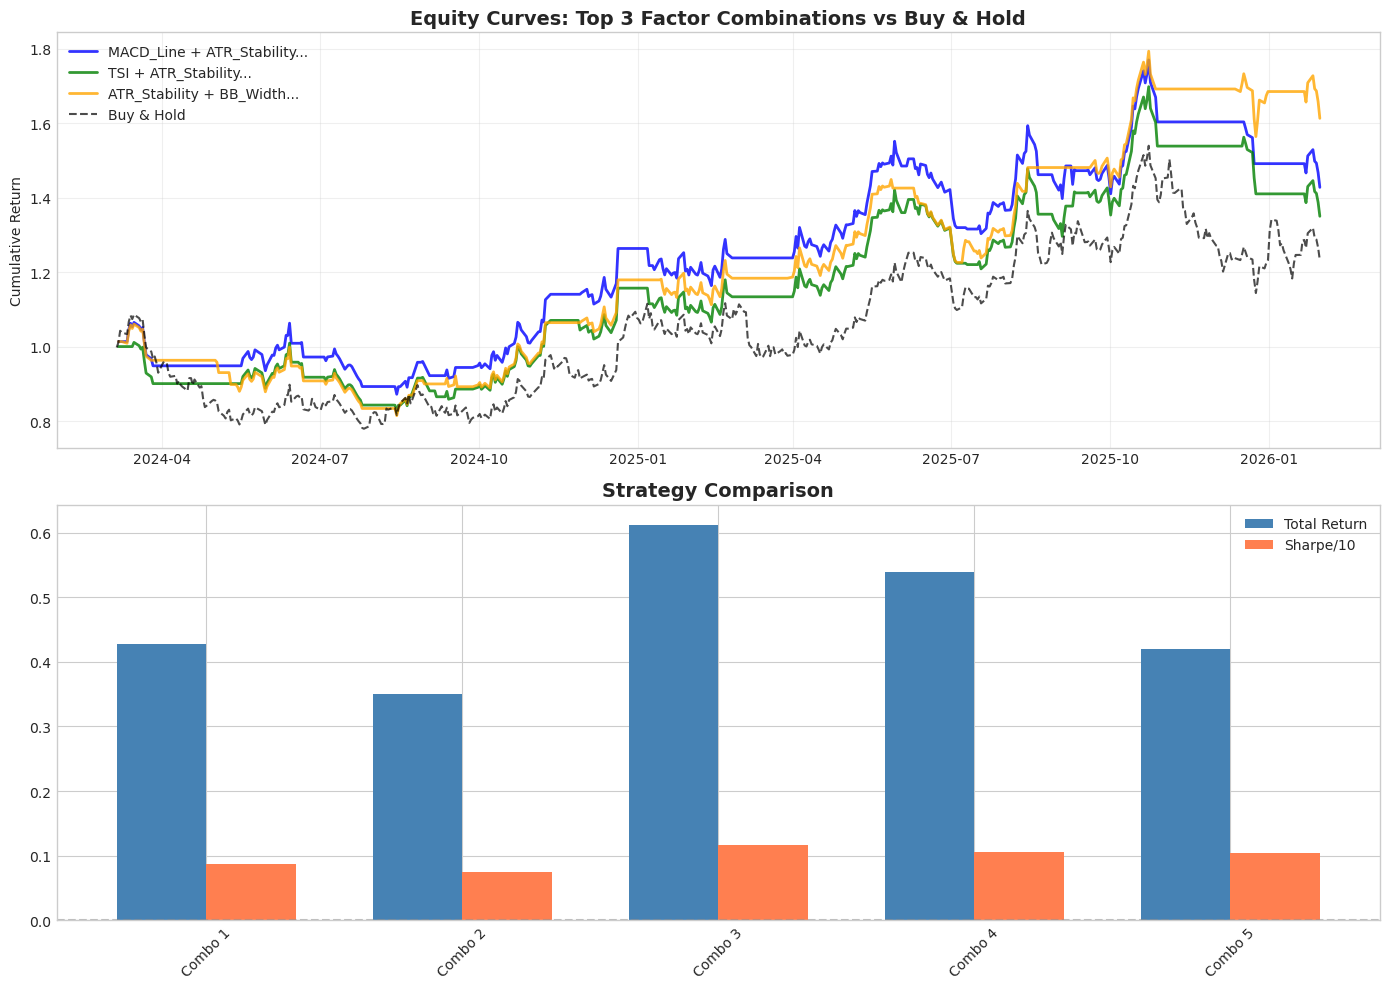


✓ Backtesting complete


In [34]:
# ══════════════════════════════════════════════════════════════════════════════
# STEP 6a: BACKTEST FACTOR COMBINATIONS
# ══════════════════════════════════════════════════════════════════════════════

print("📈 BACKTESTING TOP FACTOR COMBINATIONS")
print("=" * 60)

def backtest_combo(factors_df, returns_series, factor_combo, threshold=50):
    """Backtest a factor combination with simple strategy"""
    # Composite score (average of factors)
    composite = factors_df[list(factor_combo)].mean(axis=1)
    
    # Position: 1 if composite > threshold, else 0
    position = (composite > threshold).astype(int)
    
    # Calculate returns
    merged = pd.DataFrame({
        'position': position,
        'returns': returns_series
    }).dropna()
    
    merged['strat_ret'] = merged['position'].shift(1) * merged['returns']
    merged['cum_ret'] = (1 + merged['strat_ret']).cumprod()
    merged['bh_cum'] = (1 + merged['returns']).cumprod()
    
    # Metrics
    total_ret = merged['cum_ret'].iloc[-1] - 1
    bh_ret = merged['bh_cum'].iloc[-1] - 1
    sharpe = merged['strat_ret'].mean() / merged['strat_ret'].std() * np.sqrt(252) if merged['strat_ret'].std() > 0 else 0
    max_dd = (merged['cum_ret'] / merged['cum_ret'].cummax() - 1).min()
    win_rate = (merged['strat_ret'][merged['strat_ret'] != 0] > 0).mean() if (merged['strat_ret'] != 0).any() else 0
    
    return {
        'Factors': factor_combo,
        'Total_Return': total_ret,
        'Buy_Hold': bh_ret,
        'Excess_Return': total_ret - bh_ret,
        'Sharpe': sharpe,
        'Max_DD': max_dd,
        'Win_Rate': win_rate,
        'curve': merged[['cum_ret', 'bh_cum']]
    }

# Test top 5 combinations
returns_for_bt = ohlcv['Close'].pct_change()  # daily returns
top_5_combos = [tuple(row['Combo']) for _, row in combo_df.head(5).iterrows()]

bt_results = []
for combo in top_5_combos:
    result = backtest_combo(all_factors, returns_for_bt, combo)
    bt_results.append({
        'Combo': ' + '.join([f.replace('F_', '') for f in combo]),
        'Return': result['Total_Return'],
        'BuyHold': result['Buy_Hold'],
        'Excess': result['Excess_Return'],
        'Sharpe': result['Sharpe'],
        'MaxDD': result['Max_DD'],
        'WinRate': result['Win_Rate']
    })

bt_df = pd.DataFrame(bt_results)

print("📊 BACKTEST RESULTS:")
print("-" * 80)
print(bt_df.to_string(index=False))

# Plot equity curves
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot top 3 strategies
colors = ['blue', 'green', 'orange']
for i, combo in enumerate(top_5_combos[:3]):
    result = backtest_combo(all_factors, returns_for_bt, combo)
    curve = result['curve']
    label = ' + '.join([f.replace('F_', '') for f in combo[:2]]) + '...'
    axes[0].plot(curve.index, curve['cum_ret'], color=colors[i], linewidth=2, label=label, alpha=0.8)

# Buy & Hold
result = backtest_combo(all_factors, returns_for_bt, top_5_combos[0])
axes[0].plot(result['curve'].index, result['curve']['bh_cum'], 'k--', linewidth=1.5, label='Buy & Hold', alpha=0.7)

axes[0].set_title('Equity Curves: Top 3 Factor Combinations vs Buy & Hold', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Cumulative Return')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Bar chart comparison
metrics = ['Return', 'Sharpe']
x = np.arange(len(bt_df))
width = 0.35

axes[1].bar(x - width/2, bt_df['Return'], width, label='Total Return', color='steelblue')
axes[1].bar(x + width/2, bt_df['Sharpe']/10, width, label='Sharpe/10', color='coral')  # scaled for visibility
axes[1].set_xticks(x)
axes[1].set_xticklabels([f"Combo {i+1}" for i in range(len(bt_df))], rotation=45)
axes[1].set_title('Strategy Comparison', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\n✓ Backtesting complete")

---
### Step 6b: Parameter sweep — buy earlier/later, threshold, RSI higher/lower

For the **top factor combos**, we try different **parameter settings** and backtest each:
- **Buy earlier vs later**: composite score threshold 40 (more signals) vs 50 vs 60 (fewer, stricter)
- **RSI higher/lower**: if a combo uses RSI, we already optimized oversold/overbought in Step 5a; here we compare how threshold affects the **composite** (which blends all 4 factors)

Then we **compare** all (combo × threshold) with visualization and pick the **best combo + best parameters**.

🔧 PARAMETER SWEEP: COMPOSITE THRESHOLD (BUY EARLIER / LATER)
Threshold 40 = buy more often (earlier), 60 = buy less often (later)

📊 BEST THRESHOLD PER COMBO (by Sharpe):
----------------------------------------------------------------------
                       Combo  Threshold   Return   Sharpe     MaxDD
      ADX + ATR_Stability...         45 0.860950 1.463162 -0.268192
 ATR_Stability + BB_Width...         55 0.546656 1.189947 -0.130839
MACD_Line + ATR_Stability...         55 0.458281 1.050120 -0.136652
Stoch14_D + ATR_Stability...         55 0.547602 1.151545 -0.140482
      TSI + ATR_Stability...         55 0.356577 0.854278 -0.172463


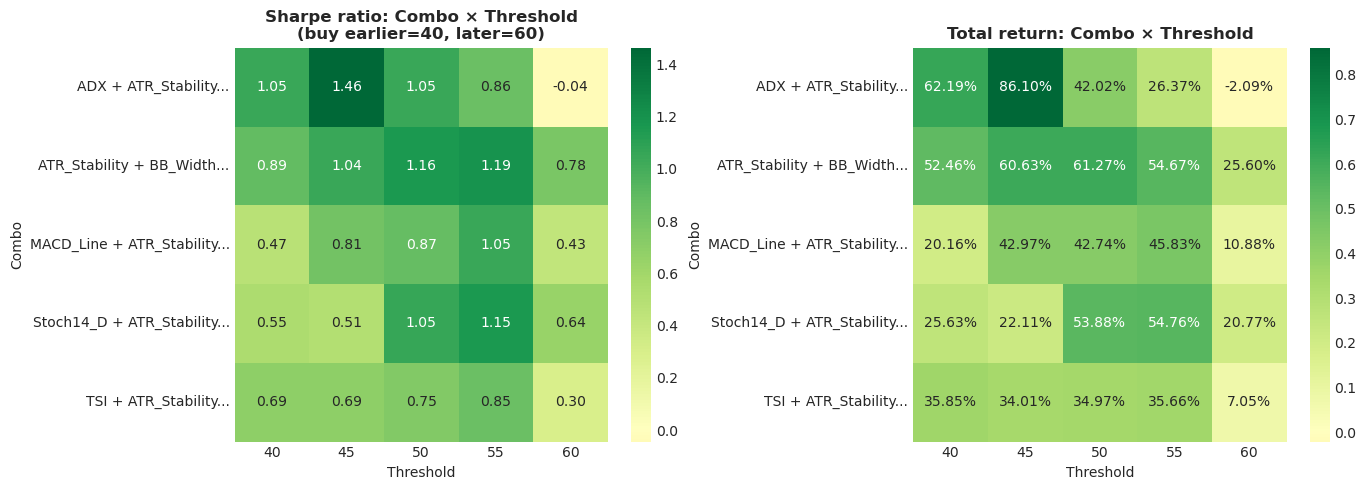


✓ BEST OVERALL: Combo = ADX + ATR_Stability..., Threshold = 45 (Sharpe = 1.463)


In [35]:
# Parameter sweep: threshold (buy earlier = 40, neutral = 50, buy later = 60)
print("🔧 PARAMETER SWEEP: COMPOSITE THRESHOLD (BUY EARLIER / LATER)")
print("=" * 70)
print("Threshold 40 = buy more often (earlier), 60 = buy less often (later)\n")

THRESHOLDS = [40, 45, 50, 55, 60]
sweep_results = []

for combo in top_5_combos:
    for thresh in THRESHOLDS:
        result = backtest_combo(all_factors, returns_for_bt, combo, threshold=thresh)
        sweep_results.append({
            'Combo': ' + '.join([f.replace('F_', '') for f in combo[:2]]) + '...',
            'Combo_Full': combo,
            'Threshold': thresh,
            'Return': result['Total_Return'],
            'Sharpe': result['Sharpe'],
            'MaxDD': result['Max_DD'],
            'WinRate': result['Win_Rate'],
        })

sweep_df = pd.DataFrame(sweep_results)

# Table: best (combo, threshold) by Sharpe
best_by_sharpe = sweep_df.loc[sweep_df.groupby('Combo')['Sharpe'].idxmax()]
print("📊 BEST THRESHOLD PER COMBO (by Sharpe):")
print("-" * 70)
print(best_by_sharpe[['Combo', 'Threshold', 'Return', 'Sharpe', 'MaxDD']].to_string(index=False))

# Heatmap: Sharpe by (Combo, Threshold)
pivot_sharpe = sweep_df.pivot_table(values='Sharpe', index='Combo', columns='Threshold', aggfunc='mean')
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(pivot_sharpe, ax=axes[0], cmap='RdYlGn', center=0, annot=True, fmt='.2f')
axes[0].set_title('Sharpe ratio: Combo × Threshold\n(buy earlier=40, later=60)', fontweight='bold')

pivot_ret = sweep_df.pivot_table(values='Return', index='Combo', columns='Threshold', aggfunc='mean')
sns.heatmap(pivot_ret, ax=axes[1], cmap='RdYlGn', center=0, annot=True, fmt='.2%')
axes[1].set_title('Total return: Combo × Threshold', fontweight='bold')
plt.tight_layout()
plt.show()

# Best overall (combo + threshold)
best_row = sweep_df.loc[sweep_df['Sharpe'].idxmax()]
print(f"\n✓ BEST OVERALL: Combo = {best_row['Combo']}, Threshold = {int(best_row['Threshold'])} (Sharpe = {best_row['Sharpe']:.3f})")
BEST_COMBO_FINAL = best_row['Combo_Full']
BEST_THRESHOLD_FINAL = int(best_row['Threshold'])

In [36]:
# 16-Scenario decision matrix (define before Final Selection step)
# (Trend, Momentum, Volatility, Volume) each 0 or 1 → action & confidence
SCENARIOS = {
    (1,1,1,1): ('STRONG_BUY', 100, 1.0),
    (1,1,1,0): ('BUY', 80, 0.8),
    (1,1,0,1): ('BUY', 75, 0.6),
    (1,1,0,0): ('SMALL_BUY', 60, 0.4),
    (1,0,1,1): ('WAIT_SMALL', 55, 0.3),
    (1,0,1,0): ('WAIT', 40, 0.0),
    (1,0,0,1): ('WAIT', 35, 0.0),
    (1,0,0,0): ('WAIT', 25, 0.0),
    (0,1,1,1): ('NO_TRADE', 30, 0.0),
    (0,1,1,0): ('NO_TRADE', 20, 0.0),
    (0,1,0,1): ('NO_TRADE', 15, 0.0),
    (0,1,0,0): ('NO_TRADE', 10, 0.0),
    (0,0,1,1): ('NO_TRADE', 15, 0.0),
    (0,0,1,0): ('NO_TRADE', 10, 0.0),
    (0,0,0,1): ('CAPITULATION', 5, 0.0),
    (0,0,0,0): ('NO_TRADE', 0, 0.0),
}

def get_decision(f1, f2, f3, f4, threshold=50):
    """Get trading decision from 4 factor scores (0-100)."""
    key = tuple(int(f >= threshold) for f in [f1, f2, f3, f4])
    return SCENARIOS[key]

print("✓ SCENARIOS and get_decision defined for Final Selection step")

✓ SCENARIOS and get_decision defined for Final Selection step


🎯 FINAL FACTOR SELECTION
(Using best combo + threshold from parameter sweep above)

✓ SELECTED 4 FACTORS (final):
----------------------------------------
  1. F_ADX                     [  TREND   ] IC: -0.1165
  2. F_ATR_Stability           [VOLATILITY] IC: +0.1349
  3. F_BB_Width                [VOLATILITY] IC: +0.2179
  4. F_CMF                     [  VOLUME  ] IC: +0.1290

📋 16 SCENARIO DECISION MATRIX
Factor order: Trend > Momentum > Volatility > Volume
1 = Factor >= 45 (GOOD), 0 = Factor < 45 (BAD)
------------------------------------------------------------
Trend Momentum Volatility Volume       Action  Confidence  Position
 GOOD     GOOD       GOOD   GOOD   STRONG_BUY         100       1.0
 GOOD     GOOD       GOOD    BAD          BUY          80       0.8
 GOOD     GOOD        BAD   GOOD          BUY          75       0.6
 GOOD     GOOD        BAD    BAD    SMALL_BUY          60       0.4
 GOOD      BAD       GOOD   GOOD   WAIT_SMALL          55       0.3
 GOOD      BAD       

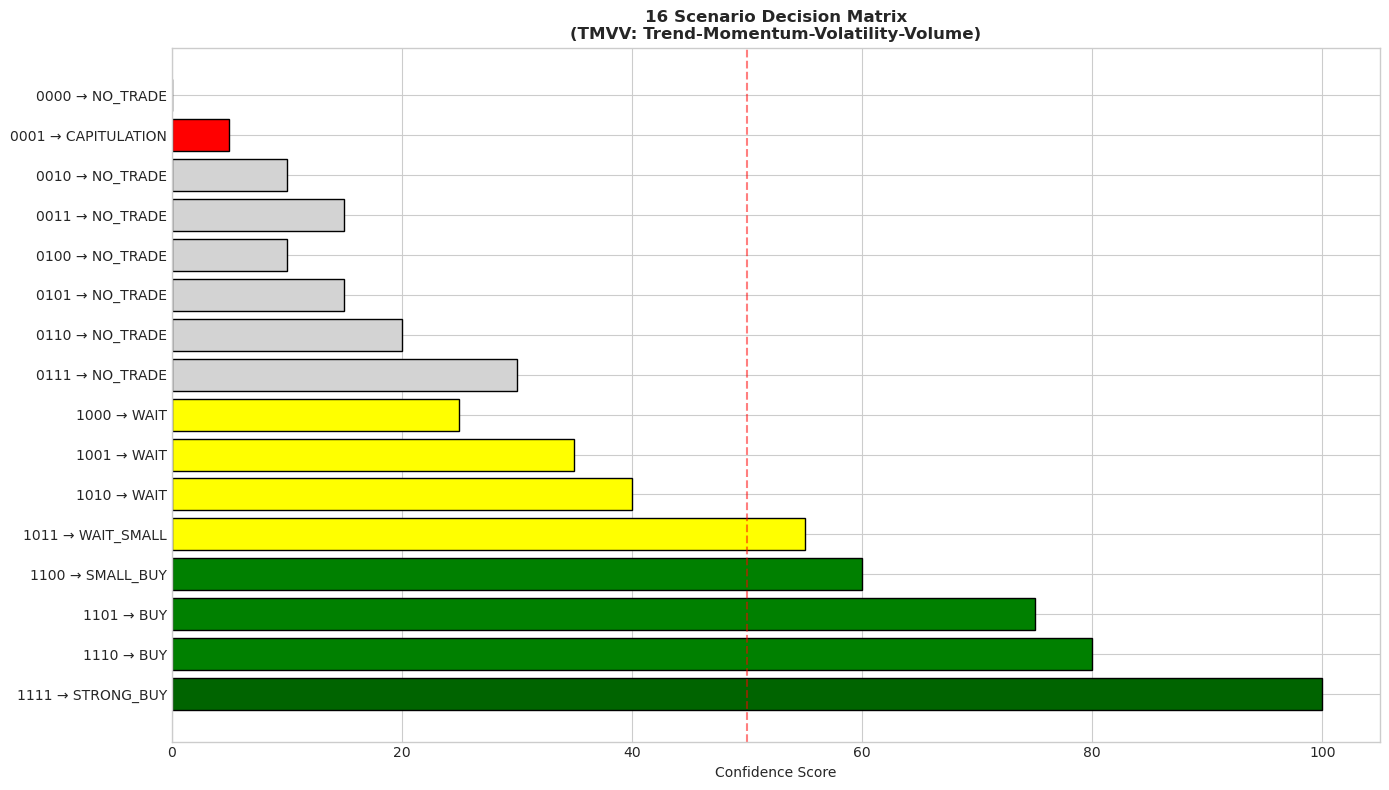


📌 CONCLUSION: BEST 4 INDICATORS & PARAMETERS
Final 4 factors: ['ADX', 'ATR_Stability', 'BB_Width', 'CMF']
Composite threshold (buy when score >= ): 45
(Use these four indicators as final in your strategy.)

✓ Final selection complete


In [37]:
# ══════════════════════════════════════════════════════════════════════════════
# STEP 7: FINAL SELECTION & DECISION SUMMARY
# ══════════════════════════════════════════════════════════════════════════════

print("🎯 FINAL FACTOR SELECTION")
print("=" * 60)

# Use best combo from parameter sweep (Step 6b) if available; else best from backtest
try:
    FINAL_FACTORS = list(BEST_COMBO_FINAL)
    FINAL_THRESHOLD = BEST_THRESHOLD_FINAL
    print("(Using best combo + threshold from parameter sweep above)\n")
except NameError:
    best_bt_idx = bt_df['Sharpe'].idxmax()
    FINAL_FACTORS = list(top_5_combos[best_bt_idx])
    FINAL_THRESHOLD = 50
    print("(Using best combo from backtest; run Step 6b for threshold sweep)\n")

print(f"✓ SELECTED 4 FACTORS (final):")
print("-" * 40)
for i, f in enumerate(FINAL_FACTORS, 1):
    ic = factor_ic.get(f, 0)
    category = "TREND" if any(x in f for x in ['MA', 'EMA', 'MACD', 'ADX', 'Super']) else \
               "MOMENTUM" if any(x in f for x in ['RSI', 'Stoch', 'Williams', 'CCI', 'ROC', 'TSI']) else \
               "VOLATILITY" if any(x in f for x in ['ATR', 'BB']) else "VOLUME"
    print(f"  {i}. {f:<25} [{category:^10}] IC: {ic:+.4f}")

# Show 16 scenario decision matrix
print("\n" + "=" * 60)
print("📋 16 SCENARIO DECISION MATRIX")
print("=" * 60)
print(f"Factor order: Trend > Momentum > Volatility > Volume")
print(f"1 = Factor >= {FINAL_THRESHOLD} (GOOD), 0 = Factor < {FINAL_THRESHOLD} (BAD)")
print("-" * 60)

scenario_display = []
for key, (action, confidence, position) in SCENARIOS.items():
    scenario_display.append({
        'Trend': 'GOOD' if key[0] else 'BAD',
        'Momentum': 'GOOD' if key[1] else 'BAD',
        'Volatility': 'GOOD' if key[2] else 'BAD',
        'Volume': 'GOOD' if key[3] else 'BAD',
        'Action': action,
        'Confidence': confidence,
        'Position': position
    })

scenario_df = pd.DataFrame(scenario_display)
print(scenario_df.to_string(index=False))

# Visualize scenario matrix
fig, ax = plt.subplots(figsize=(14, 8))

# Create heatmap-like visualization
actions = [SCENARIOS[key][0] for key in sorted(SCENARIOS.keys(), reverse=True)]
confidences = [SCENARIOS[key][1] for key in sorted(SCENARIOS.keys(), reverse=True)]
labels = [f"{k[0]}{k[1]}{k[2]}{k[3]}" for k in sorted(SCENARIOS.keys(), reverse=True)]

colors = []
for action in actions:
    if 'STRONG_BUY' in action: colors.append('darkgreen')
    elif 'BUY' in action: colors.append('green')
    elif 'SMALL_BUY' in action: colors.append('lightgreen')
    elif 'WAIT' in action: colors.append('yellow')
    elif 'NO_TRADE' in action: colors.append('lightgray')
    else: colors.append('red')

ax.barh(range(16), confidences, color=colors, edgecolor='black')
ax.set_yticks(range(16))
ax.set_yticklabels([f"{l} → {a}" for l, a in zip(labels, actions)])
ax.set_xlabel('Confidence Score')
ax.set_title('16 Scenario Decision Matrix\n(TMVV: Trend-Momentum-Volatility-Volume)', fontweight='bold')
ax.axvline(x=50, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Conclusion summary
print("\n" + "=" * 60)
print("📌 CONCLUSION: BEST 4 INDICATORS & PARAMETERS")
print("=" * 60)
print("Final 4 factors:", [f.replace('F_', '') for f in FINAL_FACTORS])
print("Composite threshold (buy when score >= ):", FINAL_THRESHOLD)
print("(Use these four indicators as final in your strategy.)")
print("\n✓ Final selection complete")

---
### Step 7b: Final backtest & comparison (chosen 4 factors + threshold)

One last backtest of the **chosen combo** with the **chosen threshold**, plus a direct comparison with Buy & Hold so we can see the improvement.

📊 FINAL COMPARISON: Chosen combo vs Buy & Hold
        Strategy   Return   Sharpe     MaxDD  WinRate
Chosen 4 factors 0.860950 1.463162 -0.268192 0.553571
      Buy & Hold 0.231393      NaN       NaN      NaN


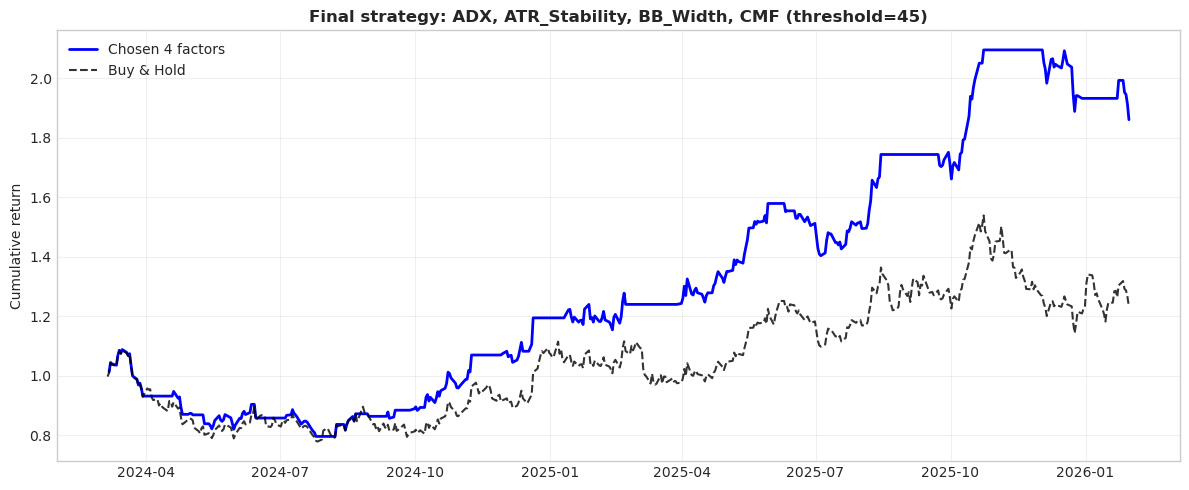


✓ Use these four indicators as final in your strategy.


In [38]:
# Final backtest: chosen 4 factors + chosen threshold
final_bt = backtest_combo(all_factors, returns_for_bt, tuple(FINAL_FACTORS), threshold=FINAL_THRESHOLD)

# Comparison table
comparison = pd.DataFrame([
    {'Strategy': 'Chosen 4 factors', 'Return': final_bt['Total_Return'], 'Sharpe': final_bt['Sharpe'], 'MaxDD': final_bt['Max_DD'], 'WinRate': final_bt['Win_Rate']},
    {'Strategy': 'Buy & Hold',      'Return': final_bt['Buy_Hold'],     'Sharpe': np.nan,            'MaxDD': np.nan,   'WinRate': np.nan},
])
print("📊 FINAL COMPARISON: Chosen combo vs Buy & Hold")
print("=" * 60)
print(comparison.to_string(index=False))

# Equity curve: strategy vs buy & hold
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(final_bt['curve'].index, final_bt['curve']['cum_ret'], 'b-', linewidth=2, label='Chosen 4 factors')
ax.plot(final_bt['curve'].index, final_bt['curve']['bh_cum'],   'k--', linewidth=1.5, label='Buy & Hold', alpha=0.8)
ax.set_title(f'Final strategy: {", ".join([f.replace("F_", "") for f in FINAL_FACTORS])} (threshold={FINAL_THRESHOLD})', fontweight='bold')
ax.set_ylabel('Cumulative return')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Use these four indicators as final in your strategy.")

In [39]:
# ══════════════════════════════════════════════════════════════════════════════
# PART 6: FINAL SELECTION & EXPORT
# ══════════════════════════════════════════════════════════════════════════════

class FinalFactors:
    """
    Final selected factors after research
    Update these after running the analysis
    """
    
    # TODO: Update after research
    SELECTED = ['F_RSI14', 'F_MA50_Trend', 'F_ATR_Stability', 'F_MFI']
    
    # Optimal parameters found
    PARAMS = {
        'RSI_PERIOD': 14,
        'RSI_OVERSOLD': 30,
        'RSI_OVERBOUGHT': 70,
        'MA_SHORT': 20,
        'MA_LONG': 50,
        'THRESHOLD': 50,
    }
    
    @classmethod
    def compute(cls, ohlcv):
        """Compute only the final selected factors"""
        all_factors = Factors.compute_all(ohlcv)
        return all_factors[cls.SELECTED]


# 16 Scenario Matrix (same as before)
SCENARIOS = {
    (1,1,1,1): ('STRONG_BUY', 100, 1.0),
    (1,1,1,0): ('BUY', 80, 0.8),
    (1,1,0,1): ('BUY', 75, 0.6),
    (1,1,0,0): ('SMALL_BUY', 60, 0.4),
    (1,0,1,1): ('WAIT_SMALL', 55, 0.3),
    (1,0,1,0): ('WAIT', 40, 0.0),
    (1,0,0,1): ('WAIT', 35, 0.0),
    (1,0,0,0): ('WAIT', 25, 0.0),
    (0,1,1,1): ('NO_TRADE', 30, 0.0),
    (0,1,1,0): ('NO_TRADE', 20, 0.0),
    (0,1,0,1): ('NO_TRADE', 15, 0.0),
    (0,1,0,0): ('NO_TRADE', 10, 0.0),
    (0,0,1,1): ('NO_TRADE', 15, 0.0),
    (0,0,1,0): ('NO_TRADE', 10, 0.0),
    (0,0,0,1): ('CAPITULATION', 5, 0.0),
    (0,0,0,0): ('NO_TRADE', 0, 0.0),
}

def get_decision(f1, f2, f3, f4, threshold=50):
    """Get trading decision from 4 factor scores"""
    key = tuple(int(f >= threshold) for f in [f1, f2, f3, f4])
    return SCENARIOS[key]


def process_final(ohlcv, threshold=50):
    """Process with final selected factors + trading decisions (threshold = buy when composite/factor >= this)."""
    factors = FinalFactors.compute(ohlcv)
    
    # Add decisions (use threshold: buy earlier=lower, buy later=higher)
    decisions = np.array([
        get_decision(*row, threshold=threshold) 
        for row in factors.values
    ])
    
    factors['Action'] = decisions[:, 0]
    factors['Confidence'] = decisions[:, 1].astype(float)
    factors['Position'] = decisions[:, 2].astype(float)
    
    return factors


def get_technical_factors(ohlcv_data=None, load_from=None):
    """Main export function for strategy designer"""
    if load_from:
        return pd.read_parquet(load_from)
    
    results = []
    for ticker, ohlcv in ohlcv_data.items():
        try:
            df = process_final(ohlcv)
            df['ticker'] = ticker
            results.append(df)
        except Exception as e:
            print(f"Error {ticker}: {e}")
    
    out = pd.concat(results).reset_index().rename(columns={'index': 'date'})
    return out.set_index(['date', 'ticker']).sort_index()


def save_factors(df, path='technical_factors.parquet'):
    df.to_parquet(path)
    print(f"Saved: {path}")

📤 EXPORT FOR STRATEGY DESIGNER
Updated FinalFactors.SELECTED = ['F_ADX', 'F_ATR_Stability', 'F_BB_Width', 'F_CMF']

📋 OUTPUT FORMAT PREVIEW:
------------------------------------------------------------
                                F_ADX  F_ATR_Stability  F_BB_Width       F_CMF        Action  Confidence  Position
2026-01-19 13:52:08.629800  13.202285        10.712320   36.750473   51.250569  CAPITULATION         5.0       0.0
2026-01-20 13:52:08.629800  12.295615         6.251412   39.463045   53.611651  CAPITULATION         5.0       0.0
2026-01-21 13:52:08.629800  11.280123        45.125972   49.214892   66.951854      NO_TRADE        30.0       0.0
2026-01-22 13:52:08.629800  10.953669        48.927143   55.879562   71.853587      NO_TRADE        30.0       0.0
2026-01-23 13:52:08.629800   9.690329        41.020266   56.208656   71.242137      NO_TRADE        15.0       0.0
2026-01-26 13:52:08.629800   8.974031        43.109934   56.727063   84.039525      NO_TRADE        15.0    

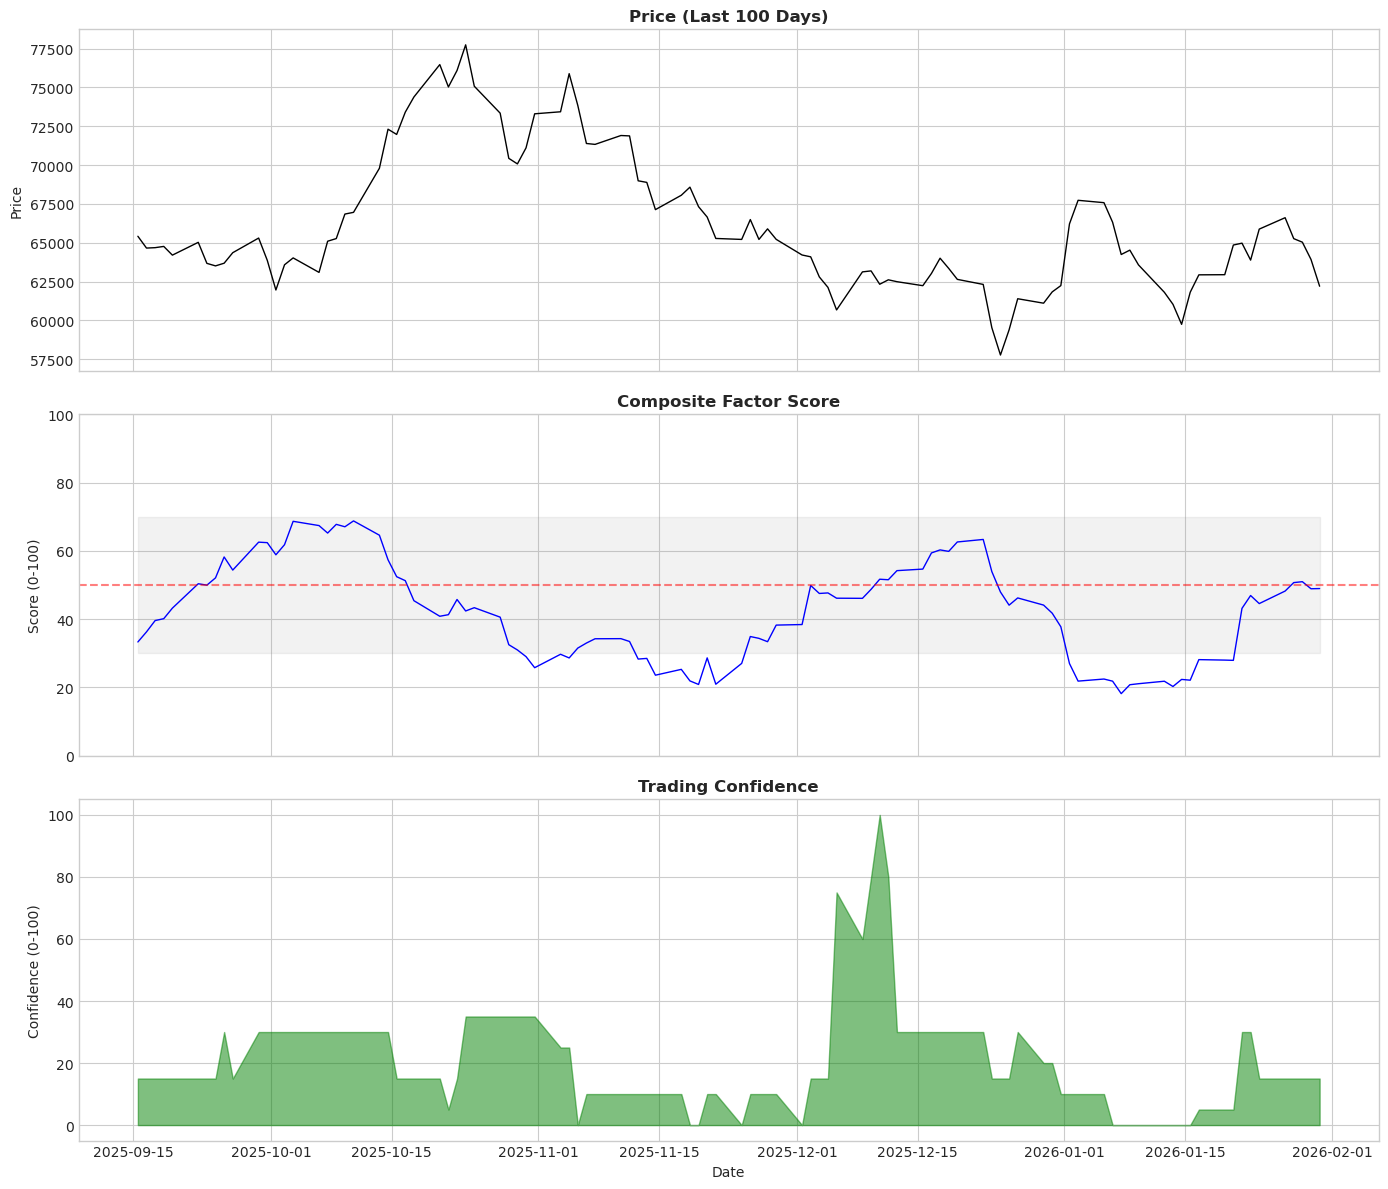


✓ READY FOR EXPORT

To export for full universe:

    # Load your data
    ohlcv_data = {ticker: load_ohlcv(ticker) for ticker in universe}

    # Generate factors for all tickers
    factors = get_technical_factors(ohlcv_data)

    # Save to parquet
    save_factors(factors, 'technical_factors.parquet')

Output format: MultiIndex DataFrame (date, ticker)
Columns: [Factor1, Factor2, Factor3, Factor4, Action, Confidence, Position]



In [40]:
# ══════════════════════════════════════════════════════════════════════════════
# STEP 8: EXPORT FOR STRATEGY DESIGNER
# ══════════════════════════════════════════════════════════════════════════════

print("📤 EXPORT FOR STRATEGY DESIGNER")
print("=" * 60)

# Update FinalFactors with selected factors from research
FinalFactors.SELECTED = FINAL_FACTORS
print(f"Updated FinalFactors.SELECTED = {FINAL_FACTORS}")

# Process sample data with final threshold (from Step 6b/7)
sample_output = process_final(ohlcv, threshold=FINAL_THRESHOLD)

print("\n📋 OUTPUT FORMAT PREVIEW:")
print("-" * 60)
print(sample_output.tail(10))

# Show decision distribution
print("\n📊 DECISION DISTRIBUTION:")
print("-" * 40)
print(sample_output['Action'].value_counts())

# Visualization of final output
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Price
axes[0].plot(ohlcv.index[-100:], ohlcv['Close'].iloc[-100:], 'k-', linewidth=1)
axes[0].set_title('Price (Last 100 Days)', fontweight='bold')
axes[0].set_ylabel('Price')

# Composite score
composite = sample_output[FINAL_FACTORS].mean(axis=1)
axes[1].plot(composite.index[-100:], composite.iloc[-100:], 'b-', linewidth=1)
axes[1].axhline(y=50, color='r', linestyle='--', alpha=0.5)
axes[1].fill_between(composite.index[-100:], 30, 70, alpha=0.1, color='gray')
axes[1].set_title('Composite Factor Score', fontweight='bold')
axes[1].set_ylabel('Score (0-100)')
axes[1].set_ylim(0, 100)

# Position/Confidence
axes[2].fill_between(sample_output.index[-100:], 0, sample_output['Confidence'].iloc[-100:], 
                      alpha=0.5, color='green', label='Confidence')
axes[2].set_title('Trading Confidence', fontweight='bold')
axes[2].set_ylabel('Confidence (0-100)')
axes[2].set_xlabel('Date')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("✓ READY FOR EXPORT")
print("=" * 60)
print("""
To export for full universe:

    # Load your data
    ohlcv_data = {ticker: load_ohlcv(ticker) for ticker in universe}
    
    # Generate factors for all tickers
    factors = get_technical_factors(ohlcv_data)
    
    # Save to parquet
    save_factors(factors, 'technical_factors.parquet')
    
Output format: MultiIndex DataFrame (date, ticker)
Columns: [Factor1, Factor2, Factor3, Factor4, Action, Confidence, Position]
""")

---
# Summary

## Research Process
```
1. Indicator Zoo (20+ indicators) → see them all
2. Factor Zoo (~30 normalized factors) → many to choose from
3. Correlation Analysis → find most uncorrelated factors
4. Try combos → score by IC + low correlation, pick top combos
5. Parameter sweeps → buy earlier/later (threshold), RSI higher/lower, MA periods
6. Backtest → each combo × threshold, compare with visualizations
7. Conclusion → best 4 factors + best parameters (use as final)
8. Export → FinalFactors.SELECTED + threshold → strategy designer
```

## Key Functions
| Function | Purpose |
|----------|--------|
| `Factors.compute_all()` | Generate all factors |
| `analyze_correlations()` | Find uncorrelated factors |
| `find_best_combos()` | Rank factor combinations |
| `optimize_rsi_thresholds()` | Find optimal RSI levels |
| `backtest_factor_combo()` | Test a combo's performance |
| `compare_factor_combos()` | Compare multiple combos |

## After Research
Update `FinalFactors.SELECTED` with your 4 chosen factors, then:
```python
factors = get_technical_factors(ohlcv_data)
save_factors(factors, 'technical_factors.parquet')
```